# Cohabit & marriage impact analysis - Preliminary analysis & problem definition


__Project objective: Understand the impact of cohabitation & marriage to mental health__

## Notebook objective
   * Gain general understanding of NLS data 
   * Define a specific problem definition (or estimand) based on what data is available


## Results
Based on data analysis, we will proceed with the problem definition (estimand) of:

__In US national longitudinal survey (NLS) 97 respondents, what is the <span style="color:green"> probability difference to scoring 8 or higher (i.e. sig. chance in having depression)</span> in the 2021 survey between the respondents that are married VS never married at the time of the survey?__

The key findings and the reasoning to the statement is stored at the bottom of the notebook


## Imports & pre-process


In [57]:
import pandas as pd
from io import StringIO
import re
from itables import init_notebook_mode
from itables import show

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import chi2_contingency
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

import pickle

from tqdm.auto import tqdm
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 14 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [58]:
#Import main data
source_file_path = 'data/tagset-05.csv'
source_df = pd.read_csv(source_file_path)

# We won't be adding new values and therefore we know the lowest/highest value of each column. 
# Downcasting to reserve memory space. Creating a quick custom function to only convert for numeric columns

def downcast_column(column):
    """Downcast columns that only stores integer values (or NaNs)
       If downcasting results in an error, then the original column will be returned
    """
    import pandas as pd
    try:
        if (pd.api.types.is_numeric_dtype(column)):
            col = pd.to_numeric(column, downcast='integer')
            #If column is (still) a floating point, preserve space by using sparse datatype
            if (col.dtype == 'float64'):
                col = col.astype(pd.SparseDtype("float", np.nan))
            return col
        else:
            return column
    except:
        print(f'Downcast failed for {column.name}')
        return column

source_df = source_df.apply(downcast_column,axis=0)


In [59]:
#Importing SDF (Short Description File) for reference. It is a fixed column width file

sdf_file_path = 'data/tagset-05.sdf'
skip_lines = 5

with open(sdf_file_path, 'r') as file:
    for _ in range(skip_lines):
        next(file)
    # Read the rest of the file into a single variable
    sdf_raw = file.read()
    
column_widths = [11,6,99,29]
sdf_io = StringIO(sdf_raw)

codebook_df = pd.read_fwf(sdf_io,widths=column_widths,header=None)
codebook_df.rename(columns = {
                        0 : 'Ref',
                        1 : 'Year',
                        2 : 'Description',
                        3 : 'Question'}
                  ,inplace=True)

#The reference value in the main source doesn't include any periods. Removing them from the codebook
codebook_df['Ref'] = codebook_df['Ref'].str.replace('.','',regex=False)


#Create modified description and question column, and start making updates (will also be modified later)
codebook_df['Modified Description'] = codebook_df['Description'].str.replace('\'','',regex=False)
codebook_df['Modified Question'] = codebook_df['Question'].str.replace('~','_',regex=False).str.replace('-','_',regex=False)

### Filter columns

In [61]:
def better_colnames(df, from_col: str, to_cols: list[str]  = ['Description','Year']):
    ''' Helper function to rename the columns in the (NLS data) df into something readable/helpful, based on data in codebook_df
    '''
    #Create dataframe with Ref column and the desired new column names based on input
    col_mapping = pd.concat([codebook_df[from_col],codebook_df[to_cols[0]].str.cat(codebook_df[to_cols[1:]],sep='_')],axis=1)    
    col_mapping.columns.values[1] = '_'.join(to_cols)
    #Convert the mapping dataframe to dictionary and rename columns
    return(df.rename(columns = col_mapping.set_index(from_col).squeeze().to_dict()))

In [62]:
# Come up with columns to be used for analysis
basic_qs = codebook_df.loc[codebook_df['Question'].str.contains('KEY!'),'Ref'].to_list()

how_often_r_qs = codebook_df.loc[codebook_df['Description'].str.contains('HOW OFTEN R ') ,'Ref' ].to_list()
depression_qs = codebook_df.loc[codebook_df['Description'].str.contains('DEPRESS') | codebook_df['Description'].str.contains('CESD') 
                                  ,'Ref' ].to_list()
cohabitation_summary_qs = codebook_df.loc[codebook_df['Question'].str.contains('FIRST_COHAB_DATE'),'Ref'].to_list()
cohabitation_monthly_qs = codebook_df.loc[codebook_df['Description'].str.contains('COHABITATION STATUS'),'Ref' ].to_list()
partners_qs = codebook_df.loc[codebook_df['Question'].str.contains('PARTNERS_ID'),'Ref'].to_list()


marital_summary_qs = codebook_df.loc[(codebook_df['Question'].str.contains('CVC_FIRST_MARRY_DATE')) | 
                                     (codebook_df['Question'].str.contains('CV_MARSTAT')),'Ref'].to_list()
marital_monthly_qs = codebook_df.loc[codebook_df['Description'].str.contains('MARITAL STATUS IN '),'Ref',].to_list()


marit_cohabit_detail_qs = codebook_df.loc[codebook_df['Question'].str.contains('MAR_STATUS_') | 
                            codebook_df['Question'].str.contains('MAR_COHABITATION') |
                            codebook_df['Question'].str.contains('MAR_PARTNER_LINK') |
                            codebook_df['Question'].str.contains('PARTNERS_UID'),'Ref'].to_list()

interview_date_qs = codebook_df.loc[codebook_df['Question'].str.contains('CV_INTERVIEW'),'Ref',].to_list()
health_qs = codebook_df.loc[codebook_df['Question'].str.contains('YHEA'),'Ref'].to_list()

cols_to_extract = basic_qs + \
    how_often_r_qs + \
    depression_qs + \
    cohabitation_summary_qs + \
    cohabitation_monthly_qs + \
    marital_summary_qs + \
    marital_monthly_qs + \
    health_qs + \
    partners_qs + \
    marit_cohabit_detail_qs + \
    interview_date_qs


In [63]:
# Use index as the respondent ID
source_df.reset_index(inplace=True,names='uid')

# Project the columns to a new dataframe
main_df = source_df.copy()

### Rename columns & map values

In [65]:
#Update basic geographic columns: 

col_renames = {
    'R0536300':'sex',
    'R0536401':'birth month',
    'R0536402':'birth year',
    'R0536600':'first interview age',
    'R0536700':'age 1996',
    'R0538600':'hispanic',
    'R0538700':'race',
    'R1482600':'race & ethnicity',
}

basic_cols = ['uid','sex','birth month','birth year','first interview age','age 1996','hispanic','race','race & ethnicity']


main_df.rename(columns = col_renames,inplace=True)

In [66]:
gender_map = {
    0: 'N/A',
    1: 'Male',
    2: 'Female'
}

race_map = {
    -2: 'Refusal',
    -1: 'Don\'t know',
    0: 'No info',
    1: 'White',
    2: 'Black or African American',
    3: 'American Indian, Eskimo, or Aleut',
    4: 'Asian or Pacific Islander',
    5: 'Something else'
    
}
race_ethnicity_map = {
    -2: 'Refusal',
    -1: 'Don\'t know',
    0: 'No info',
    1: 'Black',
    2: 'Hispanic',
    3: 'Mixed',
    4: 'Non-Black / Non-Hispanic',
}

In [67]:
main_df['race'] = main_df['race'].map(race_map).astype('category')
main_df['sex'] = main_df['sex'].map(gender_map).astype('category')
main_df['race & ethnicity'] = main_df['race & ethnicity'].map(race_ethnicity_map).astype('category')



### Create semi-tidy format version
The source (main_df) has unique rows per respondent, therefore different survey year for the same question are stored in separate columns which may be cumbersome at times. For convinience purpose, we are making a separate dataframe that is in semi-tidy format, meaning we have one row per respondent & survey year pair. (It is "semi" because there are some redundant columns that technically can be stored in a separate dataframe)

In [69]:
# Apply several manual modifications first

# SAQ-282[C~G] had different question ID for the last 2 years, updating to use same names
# CV_CESD_SCORE has different question ID for the years. Using the same ID
questions_map = {'YHEA_SAQ_282C': 'YSAQ_282C',
    'YHEA_SAQ_282D': 'YSAQ_282D',
    'YHEA_SAQ_282E': 'YSAQ_282E',
    'YHEA_SAQ_282F': 'YSAQ_282F',
    'YHEA_SAQ_282G': 'YSAQ_282G',
    'CV_CESD_SCORE_R19': 'CV_CESD_SCORE',
    'CV_CESD_SCORE_R20': 'CV_CESD_SCORE',
}

# Mental health columns - making it short
# Urban VS Rural - different description was used so fixing
descs_map = {
    'CES-D DEPRESSION - COULD NOT GET GOING (CESD)': 'CESD: COULD NOT GET GOING',
    'CES-D DEPRESSION - DEPRESSED (CESD)': 'CESD: DEPRESSED',
    'CES-D DEPRESSION - EVERYTHING TOOK EXTRA EFFORT (CESD)': 'CESD: NEED EXTRA EFFORT',
    'CES-D DEPRESSION - POOR APPETITE (CESD)': 'CESD: POOR APPETITE',
    'CES-D DEPRESSION - RESTLESS SLEEP (CESD)': 'CESD: RESTLESS SLEEP',
    'CES-D DEPRESSION - SAD (CESD)': 'CESD: SAD',
    'CES-D DEPRESSION - TROUBLE KEEPING MIND ON TASKS (CESD)': 'CESD: TROUBLE KEEPING MIND ON TASKS',
    'HOW OFTEN R DEPRESSED IN LAST MONTH': 'HOW OFTEN DEPRESSED PAST M',
    'HOW OFTEN R FELT CALM AND PEACEFUL IN PAST MONTH': 'HOW OFTEN CALM & PEACEFUL PAST M',
    'HOW OFTEN R FELT DOWN OR BLUE IN PAST MONTH': 'HOW OFTEN DOWN OR BLUE PAST M',
    'HOW OFTEN R HAS BEEN A HAPPY PERSON IN PAST MONTH': 'HOW OFTEN HAPPY PAST M',
    'HOW OFTEN R HAS BEEN A NERVOUS PERSON IN PAST MONTH': 'HOW OFTEN NERVOUS PAST M',
    'CURRENT RESIDENCE IN URBAN OR RURAL AREA - 2000 CENSUS STANDARDS': 'CURRENT RESIDENCE IN URBAN OR RURAL AREA',
    'CURRENT RESIDENCE IN URBAN OR RURAL AREA - 2010 CENSUS STANDARDS': 'CURRENT RESIDENCE IN URBAN OR RURAL AREA',
    'CURRENT RESIDENCE IN URBAN OR RURAL AREA - 2020 CENSUS STANDARDS': 'CURRENT RESIDENCE IN URBAN OR RURAL AREA',
    
}

codebook_df['Modified Question'] = codebook_df['Modified Question'].map(questions_map).fillna(codebook_df['Modified Question'])
codebook_df['Modified Description'] = codebook_df['Modified Description'].map(descs_map).fillna(codebook_df['Modified Description'])


In [70]:
# In order to combine columns that are the same question but stored in different columns, we will use the "Question" and the "Description" 
# to decide which columns should be merged. Note that the merging is not exhaustive, and may do more as needed. 

def extract_numbers(text):
    return re.findall(r'\d+', text)

# Create new column to make numbers in the description (for merging), and store them separately
codebook_df['Modified Description'] = codebook_df['Modified Description'].str.replace(r'\d','x',regex=True)
codebook_df['Numbers'] = codebook_df['Description'].apply(extract_numbers)

# Initialize a dictionary to keep track of counts of each name
qs_descs = {}


def make_unique(row):
    """ Function to determine the unique Question to be assigned to each cookbook row. 
        This step is a bit complicated because somehow NLS decided to allow having totally different question
        using the same question ID. For example, YSAQ-INTRO-3 can be "Favorite ice cream?" question and 
        "Currently have access to internet?" Therefore, in order to avoid accidental merge of question, we add a 
        numerical suffix to indicate it's different. 
    """
    description = row['Modified Description']
    question = row['Modified Question']
    if question in qs_descs:
        if description in qs_descs[question]:
            if qs_descs[question].index(description) == 0:
                return question
            else:
                return question +'__' +  str(qs_descs[question].index(description))
        else:
            qs_descs[question].append(description)
            return question + '__' + str(qs_descs[question].index(description))
    else:
        qs_descs[question] = [description]        
        return question

codebook_df['Modified Question'] = codebook_df.apply(make_unique,axis=1)

In [71]:
# With the new question names in codebook_book, we will create tidy_df

tidy_df = pd.melt(main_df,id_vars=basic_cols,var_name='Ref')
ref_modq_map = codebook_df.set_index('Ref')['Modified Question'].to_dict()
tidy_df['Modified Question'] = tidy_df['Ref'].map(ref_modq_map)
ref_year_map = codebook_df.set_index('Ref')['Year'].to_dict()
tidy_df['Year'] = tidy_df['Ref'].map(ref_year_map)

tidy_df = tidy_df.pivot(index=basic_cols + ['Year'], columns='Modified Question', values='value').reset_index().reset_index()


#Converting 'XRND' value to 0 for Year, so it can be turned into integer column
tidy_df.loc[tidy_df['Year'] == 'XRND','Year'] = '0'
tidy_df.loc[tidy_df['Year'] == 'HSTR','Year'] = '0'

tidy_df['Year'] = tidy_df['Year'].astype(int)
tidy_df = tidy_df.loc[tidy_df['race'] != 0]

#Remove rows when observation wasn't done for the respondent
tidy_df = tidy_df[tidy_df['YHEA_100'] > 0]

#downcasting to reduce memory space
tidy_df = tidy_df.apply(downcast_column)

In [72]:
# Create a new dataframe for storing last interview Year, and year-month, and store as a flag in tidy_df
interview_df = tidy_df[['uid','Year','CV_INTERVIEW_DATE_M','CV_INTERVIEW_DATE_Y']].sort_values(by=['uid','Year'])
interview_df = interview_df[interview_df['CV_INTERVIEW_DATE_M'].notnull()]
interview_df = interview_df[interview_df['CV_INTERVIEW_DATE_M']>0]
interview_df['CV_INTERVIEW_DATE_M'] = interview_df['CV_INTERVIEW_DATE_M'].sparse.to_dense().astype(int).astype(str)
interview_df['CV_INTERVIEW_DATE_Y'] = interview_df['CV_INTERVIEW_DATE_Y'].sparse.to_dense().astype(int).astype(str)
interview_df['CV_INTERVIEW_DATE_M'] = ('0' + interview_df['CV_INTERVIEW_DATE_M']).str[-2:]
interview_df['interview_year-month'] = interview_df['CV_INTERVIEW_DATE_Y'].astype(str) + '-' +  interview_df['CV_INTERVIEW_DATE_M'].astype(str) 
last_interview_df = interview_df.groupby('uid')[['interview_year-month','Year']].max()
last_interview_df.reset_index(inplace=True)
last_interview_df = last_interview_df.rename(columns={'interview_year-month':'last_interview_year-month',
                                                      'Year':'last_interview_Year'})

tidy_df.drop('last_interview_Year',axis=1,inplace=True,errors='ignore')
tidy_df = tidy_df.merge(last_interview_df.loc[:,['uid','last_interview_Year']],how='left',left_on=['uid','Year'],right_on=['uid','last_interview_Year'])
tidy_df['last_interview'] = tidy_df['last_interview_Year'].map(lambda x: False if np.isnan(x) else True)
tidy_df.drop('last_interview_Year',axis=1,inplace=True)
tidy_df.columns.name = ''

## Preliminary data analysis

Following are some of the questions that should be answered via the preliminary analysis to come up with the right problem statement and/or estimand: 
   * Do we have enough respondents that have been married/cohabitted long enough for analysis?
   * How can we define the control set (unmarried/uncohabitted) and compare? 
      * One way would be to compare respondents that got cohabitted/married at some age VS respondents that weren't cohabitted/married on the same age, and compare the mental health status assuming the cohabit/married status doesn't change during which the metric (mental health) is compared
      * Binning of age group may be required to have enough sample set to compare
   * Should we only look at first cohabit/marriage, or any cohabit/marriage?
      * First cohabit/marriage may have different effect than subsequent ones 
      * We may not have enough datapoints to only look at the first cohabit/marriage anyways
   * Which data source/column should we use for mental health? 
      * There is the formal CES-D (Center for Epidemiologic Studies Depression Scale, but is only available 2019 and 2021
      * There are sets of questions (YSAQ-282C~G) that's being asked every survey year related to mental health, but there's no standard way on how to use & aggregate them. 
      * We also need to consider if we should use some point in time (e.g. 3 years after marriage), or aggregate over time
   * At high level, do we see noticeable differences in mental health between married/cohabitted vs unmarried/uncohabitted? 
      * High level aggregate cannot conclude any differences when looking in finer granularity, but it is the first sign to peek interest
      
_Note: In this analysis we are not evaluating which variables may be used as variables for regression/prediction._

### Participant age in 1996 (first year of survey)
__Observation__
   * Age ranges from 12~16, and mostly uniformly distributed

In [75]:
main_df['age 1996'].value_counts().sort_index()

12    1771
13    1807
14    1841
15    1874
16    1691
Name: age 1996, dtype: int64

### Dropout rate
__Observation__
   * By the last interview (2021), about 77% remain
   * There isn't a big dropout different between gender, although it seems male is dropping out slightly faster
   * The dropout rate is fastest for white among all races, 

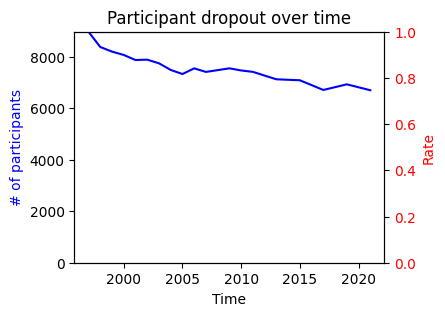

In [77]:
#Looking at participant engagement

agg_YHEA_100 = {
    'YHEA_100': ['sum', 'mean'],
}

participation_stats = pd.concat([tidy_df['Year'],tidy_df['YHEA_100'].apply(lambda x: x!= -5)],axis=1).groupby('Year').agg(agg_YHEA_100)
participation_stats = participation_stats[participation_stats.index != 0]

fig, ax1 = plt.subplots(figsize=(4, 3))

# Create a twin Axes sharing the x-axis
ax2 = ax1.twinx()

# Plot a line plot on the first y-axis
sns.lineplot(x='Year', y=('YHEA_100','sum'), data=participation_stats,ax=ax1,color='blue')
ax1.set_ylabel('# of participants', color='blue')

# Plot a bar plot on the second y-axis
sns.lineplot(x='Year', y=('YHEA_100','mean'), data=participation_stats,ax=ax2, color='blue')
ax2.set_ylabel('Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Customize the plot
ax1.set_xlabel('Time')
ax1.set_title('Participant dropout over time')
ax1.set_ylim(0, participation_stats.iloc[0,0])
ax2.set_ylim(0, 1.0)

# Show the plot
plt.show()

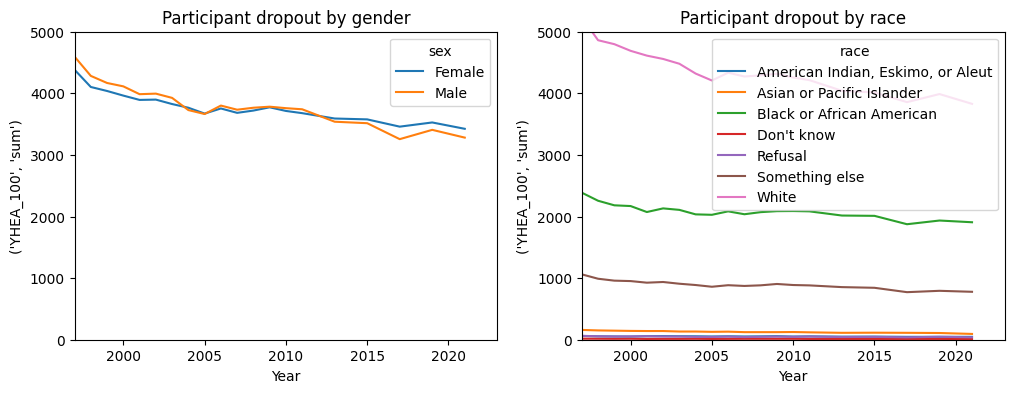

In [78]:
#Looking at participant engagement

agg_YHEA_100 = {
    'YHEA_100': ['sum', 'mean'],
}

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

participation_stats = pd.concat([tidy_df[['Year','sex']],tidy_df['YHEA_100'].apply(lambda x: x!= -5)],axis=1).groupby(['Year','sex']).agg(agg_YHEA_100)
participation_stats = participation_stats[participation_stats.index != 0]
sns.lineplot(x='Year', y=('YHEA_100','sum'), hue='sex',data=participation_stats,palette='tab10',ax=axs[0])
axs[0].set_title('Participant dropout by gender')
axs[0].set_xlim(1997,2023)
axs[0].set_ylim(0,5000)


participation_stats = pd.concat([tidy_df[['Year','race']],tidy_df['YHEA_100'].apply(lambda x: x!= -5)],axis=1).groupby(['Year','race']).agg(agg_YHEA_100)
participation_stats = participation_stats[participation_stats.index != 0]
sns.lineplot(x='Year', y=('YHEA_100','sum'), hue='race',data=participation_stats,palette='tab10',ax=axs[1])
axs[1].set_title('Participant dropout by race')
axs[1].set_xlim(1997,2023)
axs[1].set_ylim(0,5000)
plt.show()

### Cohabitation & marriage

<details>
    <summary><b>Code mapping for cohabit and marriage related data</b></summary>
    
__CODE FOR MAR_COHABITATION__
   * 101 Cohabiting with partner 1
   * 102 Cohabiting with partner 2
   * 103 Cohabiting with partner 3
   * 104 Cohabiting with partner 4
   * 105 Cohabiting with partner 5
   * 106 Cohabiting with partner 6
   * 107 Cohabiting with partner 7
   * 108 Cohabiting with partner 8
   * 109 Cohabiting with partner 9
   * 110 Cohabiting with partner 10
   * 111 Cohabiting with partner 11
   * 201 Cohabiting with spouse 1
   * 202 Cohabiting with spouse 2
   * 203 Cohabiting with spouse 3
   * 204 Cohabiting with spouse 4
   * 205 Cohabiting with spouse 5
   * 206 Cohabiting with spouse 6
   * 207 Cohabiting with spouse 7
   * 208 Cohabiting with spouse 8
   * 209 Cohabiting with spouse 9
   * 210 Cohabiting with spouse 10

__CODE FOR MAR_STATUS__
   * 0 Never Married, Not Cohabitating
   * 1 Never Married, Cohabiting
   * 2 Married
   * 3 Legally Separated
   * 4 Divorced
   * 5 Widowed

__CODE FOR CV_MARSTAT__
   * 1 Never married, cohabiting
   * 2 Never married, not cohabiting
   * 3 Married, spouse present
   * 4 Married, spouse absent
   * 5 Separated, cohabiting
   * 6 Separated, not cohabiting
   * 7 Divorced, cohabiting
   * 8 Divorced, not cohabiting
   * 9 Widowed, cohabiting
   * 10 Widowed, not cohabiting
<details>

#### Basic stats + women VS men
__Observation__ 
   * ~30% more people seem to have at least married once
   * More women seems to have cohabited & married at least once than men 
      * Further analysis may be skewed towards women if not conditioned
   * Women gets their first cohabit/marriage earlier than man
      * Not a large diff, but may need to watch out if age is a factor in the analysis

Text(0.5, 1.0, 'Partner status @ last interview')

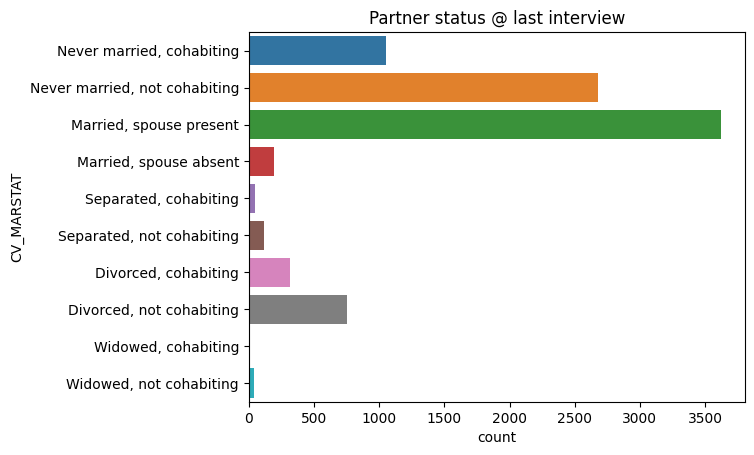

In [82]:
cv_marstat_map = {1: 'Never married, cohabiting',
                2: 'Never married, not cohabiting',
                3: 'Married, spouse present',
                4: 'Married, spouse absent',
                5: 'Separated, cohabiting',
                6: 'Separated, not cohabiting',
                7: 'Divorced, cohabiting',
                8: 'Divorced, not cohabiting',
                9: 'Widowed, cohabiting',
                10: 'Widowed, not cohabiting'}

temp_df = tidy_df.loc[tidy_df['last_interview']==True,'CV_MARSTAT'].map(cv_marstat_map).to_frame()
sns.countplot(data=temp_df, y='CV_MARSTAT', order = cv_marstat_map.values()).set_title("Partner status @ last interview")


Text(0.5, 1.0, 'Age of first marriage')

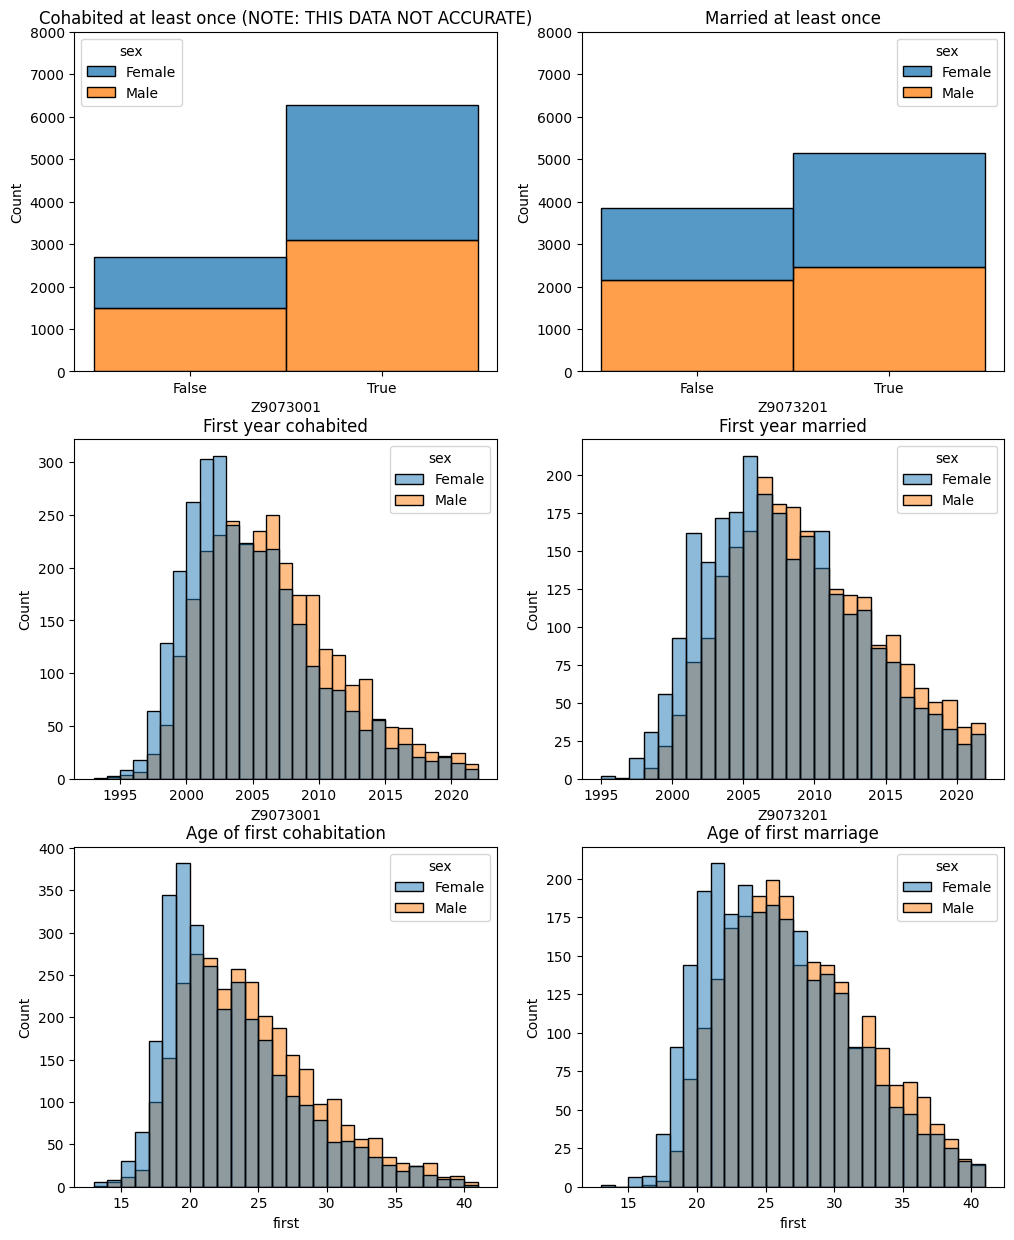

In [83]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

# Z9073001 = YEAR OF FIRST COHABITATION
# Note: This data is actually not accurate, based on comment from the codebook. 
# COMMENT: This variable does not record a cohabitation date for respondents who 
# first begin living with a partner at the same time they are first married to 
# that partner; that date will appear in CV_FIRST_MARRY_MONTH/_DATE only.  If the 
# respondent cohabitates with a different partner after the marriage, it will be 
# recorded in this variable; thus, first cohabitation does not always preceed 
# first marriage.
# However this is just for preliminary analysis and therefore we will keep as is. If needed there are other ways 
# to extract this data
# 
sns.histplot(x=main_df['Z9073001'].apply(lambda x: x != -4).astype(str), hue=main_df['sex'], multiple='stack', discrete=True, ax = axs[0,0])
axs[0,0].set_title("Cohabited at least once (NOTE: THIS DATA NOT ACCURATE)")
axs[0,0].set_ylim(0, 8000)



# Z9073201 = YEAR OF FIRST Marriage
sns.histplot(x=main_df['Z9073201'].apply(lambda x: x != -4).astype(str), hue=main_df['sex'], multiple='stack', discrete=True, ax = axs[0,1])
axs[0,1].set_title("Married at least once")
axs[0,1].set_ylim(0, 8000)

cohabit_df = main_df.loc[main_df['Z9073001']>1900,['Z9073001','age 1996','sex']]
cohabit_df['first'] = cohabit_df['Z9073001'] - (1996 - cohabit_df['age 1996'])
married_df = main_df.loc[main_df['Z9073201']>1900,['Z9073201','age 1996','sex']]
married_df['first'] = married_df['Z9073201'] - (1996 - married_df['age 1996'])


sns.histplot(x=cohabit_df['Z9073001'],hue=cohabit_df['sex'],ax = axs[1,0],binwidth=1)
axs[1,0].set_title("First year cohabited")


sns.histplot(x=married_df['Z9073201'],hue=married_df['sex'],ax = axs[1,1],binwidth=1)
axs[1,1].set_title("First year married")


sns.histplot(data=cohabit_df,x='first',hue='sex',ax = axs[2,0],binwidth=1)
axs[2,0].set_title("Age of first cohabitation")


sns.histplot(data=married_df,x='first',hue='sex', ax = axs[2,1],binwidth=1)
axs[2,1].set_title("Age of first marriage")



#### Length of cohabit & marriage
__Observation__
   * For cohabit, at least half of the cohabits lasts less than a year
   * For marriage, the curve is softer than cohabit, and more marriages are ongoing (as of last interview). 
   * There seems to be at least 200 or so cohabitation & marriage for each duration
   * If the marriage is ongoing or not is pretty tricky, since there are people that dropped off the survey

In [85]:
# In this dataset, getting the right cohabit length is tricky because you can have a "cohabit" status in a month and then into "married" status
# in month+1 but for the same person. Therefore we need to map each respondent-year's cohabit partner and calculate the cohabit length based on 
# the partner ID. 

# First, make partner dataframe that stores each respondent's cohabit, marriage status and partner ID per year
cols = ['uid'] + codebook_df.loc[codebook_df['Question'].str.contains('MAR_STATUS') |
                                codebook_df['Question'].str.contains('MAR_COHABITATION') |
                                codebook_df['Question'].str.contains('MAR_PARTNER_LINK') ,'Ref'].to_list()
partner_df = better_colnames(main_df.loc[:,cols],'Ref',['Question']).melt(id_vars='uid').sort_values(by=['uid','variable'])
partner_df['value'] = partner_df['value'].map(lambda x: None if x < 0 else x)
extract_df = partner_df['variable'].str.extract(r'(.*)_(\d\d\d\d)\.(\d\d)$').rename(columns={0:'type',1:'year',2:'month'})
partner_df = partner_df.merge(extract_df,left_index=True,right_index=True)
partner_df['year-month'] = partner_df['year'] +'-'+ partner_df['month']
partner_df = partner_df.pivot(index=['uid','year-month','year','month'],columns='type',values='value').reset_index()

# Create cohabit dataframe that stores each respondent's cohabit experience per row and its duration. 
# Also include a flag if the cohabit is ongoing (i.e. the status of cohabit for the last interview of that respondent)
cohabit_stats_df = partner_df.groupby(['uid','MAR_COHABITATION','MAR_PARTNER_LINK']).agg(
    cohabit_months=('year-month','count'),
    cohabit_start=('year-month','min'),
    cohabit_end=('year-month','max')
).reset_index()
cohabit_stats_df = cohabit_stats_df.merge(last_interview_df, how='left',left_on = ['uid'], right_on = ['uid'])
cohabit_stats_df['ongoing'] = (cohabit_stats_df['cohabit_end'] == cohabit_stats_df['last_interview_year-month'])
cohabit_stats_df['cohabit_years'] = cohabit_stats_df['cohabit_months'] / 12

# Do similar for marriage status
marriage_stats_df = partner_df.loc[partner_df['MAR_STATUS']==2,:].groupby(['uid','MAR_STATUS','MAR_PARTNER_LINK']).agg(
    marriage_months=('year-month','count'),
    marriage_start=('year-month','min'),
    marriage_end=('year-month','max')
).reset_index()
marriage_stats_df = marriage_stats_df.merge(last_interview_df, how='left',left_on = ['uid'], right_on = ['uid'])
marriage_stats_df['ongoing'] = (marriage_stats_df['marriage_end'] == marriage_stats_df['last_interview_year-month'])
marriage_stats_df['marriage_years'] = marriage_stats_df['marriage_months'] / 12



Text(0.5, 1.0, 'Length of marriage w/ same partner')

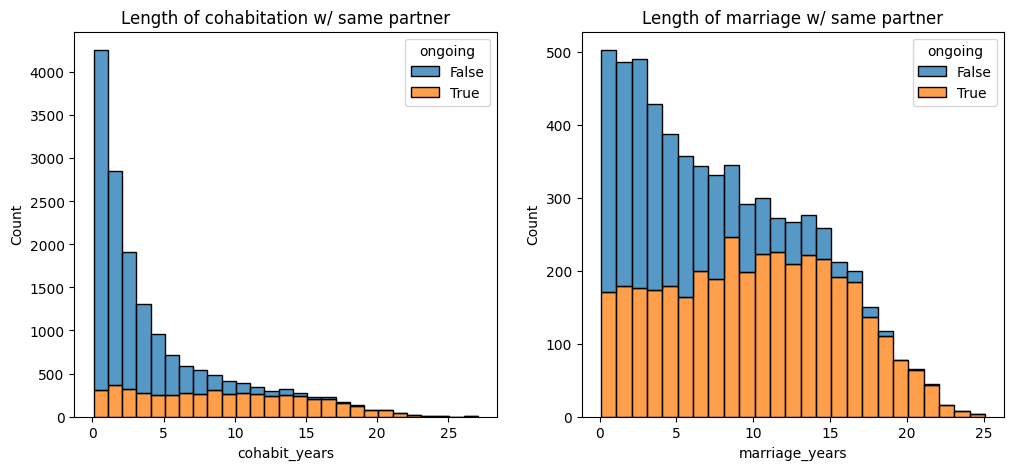

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(cohabit_stats_df,x='cohabit_years',hue='ongoing',multiple='stack',binwidth=1, ax=axs[0])
axs[0].set_title("Length of cohabitation w/ same partner")

sns.histplot(marriage_stats_df,x='marriage_years',hue='ongoing',multiple='stack',binwidth=1, ax=axs[1])
axs[1].set_title("Length of marriage w/ same partner")



### Mental health

__Planned analysis:__
   * Average score of each per age (maybe box plot) 
   * Correlation of CESD score (or Depressed score) with R How often depressed
   * Compare CESC score and R How often... between married, cohabitted and not
   
   
Notes: 
   * The CES-D score is the 7 question (i.e. light version) instead of the full version (20 questions). There isn't clear threshold on at what point it shows depression, however some study suggests score of [8](https://link.springer.com/article/10.1007/s00127-012-0650-2) or [9](https://www.mdpi.com/1660-4601/18/3/1361) or higher to have significant likelihood of depression. We will go with the higher value of 9 for the analysis 

In [89]:
# Data prep
mental_health_cols = codebook_df.loc[codebook_df['Ref'].isin(how_often_r_qs + depression_qs),'Modified Question'].to_list()
mental_health_cols = sorted(list(set(mental_health_cols)))
mental_health_df = better_colnames(tidy_df.loc[:,['uid','Year'] + mental_health_cols],from_col='Modified Question',to_cols=['Modified Description'])

#### Score distribution of "How often..." questions

__Observation__ 
   * (Nothing notable)

In [91]:
temp_df = mental_health_df.melt(id_vars=['uid','Year'],var_name = 'Modified Question')
mental_health_pivot_df = pd.pivot_table(temp_df,values='uid',index=['Modified Question','Year'],columns='value',aggfunc='count').transpose().reset_index()

mental_health_pivot_df = (mental_health_pivot_df.loc[(mental_health_pivot_df['value'] >= 0) & (mental_health_pivot_df['value'] <= 4),:])

#Reorder columns
cols = sorted(mental_health_pivot_df.columns.tolist())
cols = cols[-1:] + cols[:-1]
mental_health_pivot_df = mental_health_pivot_df[cols]

#Show percentage of each count per column
column_totals = mental_health_pivot_df.sum(axis=0)
percentage_df = mental_health_pivot_df.div(column_totals, axis=1) * 100
show((mental_health_pivot_df.astype(str) + ' (' + percentage_df.round(2).astype(str) + '%)').reset_index().transpose())


#### CES-D score distribution
   * We have about 700 people that have score 9 or above (significant likelihood of being depressed). This is ~10% of the total surveyor

C:\Users\hiron\AppData\Local\Temp\ipykernel_11452\1914407984.py:6: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  temp_df = temp_df.groupby(['Rxx CESD SCORE (x ITEM)','Year'])['uid'].count().reset_index()


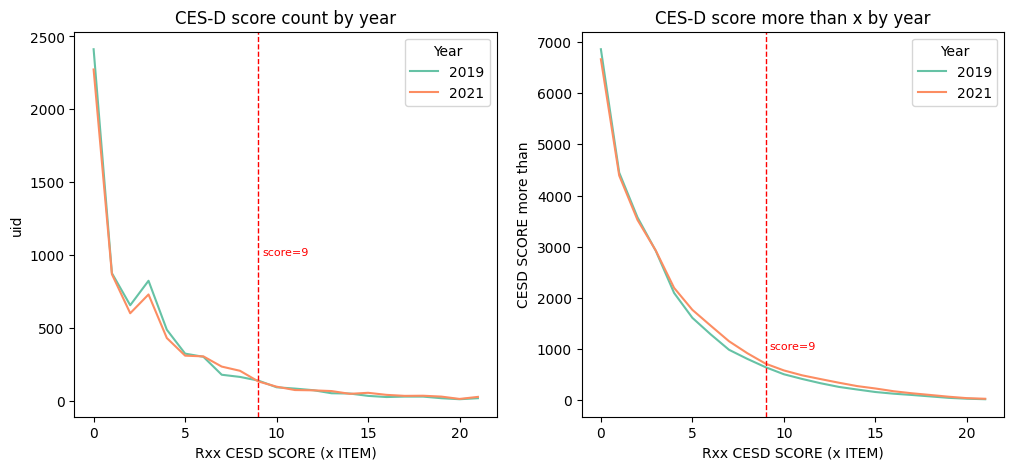

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

def reverse_cumsum(series):
    return series[::-1].cumsum()[::-1]
temp_df = mental_health_df.loc[mental_health_df['Rxx CESD SCORE (x ITEM)'] >= 0,:]
temp_df = temp_df.groupby(['Rxx CESD SCORE (x ITEM)','Year'])['uid'].count().reset_index()
temp_df['CESD SCORE more than'] = temp_df.groupby('Year')['uid'].transform(reverse_cumsum)


sns.lineplot(temp_df,x='Rxx CESD SCORE (x ITEM)',y='uid',hue='Year',ax=axs[0],palette='Set2')
axs[0].set_title("CES-D score count by year")
axs[0].axvline(x=9, color='r', linestyle='--', linewidth=1)
axs[0].annotate('score=9', xy=(9, 1000), xytext=(9.2, 1000),
              fontsize=8, color='red')

sns.lineplot(temp_df,x='Rxx CESD SCORE (x ITEM)',y='CESD SCORE more than',hue='Year',ax=axs[1],palette='Set2')
axs[1].set_title("CES-D score more than x by year")
axs[1].axvline(x=9, color='r', linestyle='--', linewidth=1)
axs[1].annotate('score=9', xy=(9, 1000), xytext=(9.2, 1000),
             fontsize=8, color='red')

plt.show()

#### CESD score > 8

__Observations__
   * The % of respondents that have high CESD score (7/8 or higher) has increased between 2019 and 2021 
   * The percentage of "Score > 7" seems to match better "Score > 8" when comparing with Gallup
      * Score > 7: 11.6% -> 13.6%
      * Score > 8: 9.3% -> 10.6%
      * Gallup (US National): 12.5% -> ~15% (It seems the 2021 has not been measured though)
<div>
<img src="https://content.gallup.com/origin/gallupinc/GallupSpaces/Production/Cms/POLL/yjjzxejyak6dopzsjndwxw.png" width="50%"/>
<br>    <a href='https://news.gallup.com/poll/505745/depression-rates-reach-new-highs.aspx'> source</a>
</div>


In [96]:

mental_health_df['CESD > 8'] = (mental_health_df['Rxx CESD SCORE (x ITEM)'] > 8)
temp_df = mental_health_df.loc[mental_health_df['Year'].isin([2019,2021]),['CESD > 8','Year']]
temp_df = temp_df.value_counts().to_frame().reset_index().pivot(columns='Year',index='CESD > 8')
print(temp_df)

print('')
print(f'2019 % of respondents w/ CESD score > 8: {temp_df.iloc[1,0] / (temp_df.iloc[0,0] + temp_df.iloc[1,0])}')
print(f'2021 % of respondents w/ CESD score > 8: {temp_df.iloc[1,1] / (temp_df.iloc[0,1] + temp_df.iloc[1,1])}')


print('\n')
mental_health_df['CESD > 7'] = (mental_health_df['Rxx CESD SCORE (x ITEM)'] > 7)
temp_df = mental_health_df.loc[mental_health_df['Year'].isin([2019,2021]),['CESD > 8','Year']]
temp_df = temp_df.value_counts().to_frame().reset_index().pivot(columns='Year',index='CESD > 8')
print(temp_df)

print('')
print(f'2019 % of respondents w/ CESD score > 7: {temp_df.iloc[1,0] / (temp_df.iloc[0,0] + temp_df.iloc[1,0])}')
print(f'2021 % of respondents w/ CESD score > 7: {temp_df.iloc[1,1] / (temp_df.iloc[0,1] + temp_df.iloc[1,1])}')

             0      
Year      2019  2021
CESD > 8            
False     6291  5993
True       643   712

2019 % of users w/ CESD score > 8: 0.09273146812806461
2021 % of users w/ CESD score > 8: 0.10618941088739746


             0      
Year      2019  2021
CESD > 8            
False     6291  5993
True       643   712

2019 % of users w/ CESD score > 7: 0.09273146812806461
2021 % of users w/ CESD score > 7: 0.10618941088739746


C:\Users\hiron\AppData\Local\Temp\ipykernel_11452\1265800974.py:3: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  temp_df = temp_df.value_counts().to_frame().reset_index().pivot(columns='Year',index='CESD > 8')
C:\Users\hiron\AppData\Local\Temp\ipykernel_11452\1265800974.py:3: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  temp_df = temp_df.value_counts().to_frame().reset_index().pivot(columns='Year',index='CESD > 8')
C:\Users\hiron\AppData\Local\Temp\ipykernel_11452\1265800974.py:3: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtyp

#### Estimating CESD score from "How often..." scores
   * CES-D survey was only done in 2019 and 2021, compared to "How often..." questions which were done almost every survey year
   * Therefore, if we can infer the CES-D score from the "How often..." questions, then we have more data points for mental health analysis
   
__Results__ 
   * Several models (linear, neg. binomial, decision tree) were tested, however the predictions weren't good enough (e.g. MSE: 8.7) to be used as an alternative to the real CES-D score
   * Even if we only try to separate "score <= 8" and "score > 8", it wasn't great (e.g. f1 score: 0.48, see confusion matrix)
   * There are some data points that doesn't make sense. For example the CES-D score is 21, but the person claimed happy all the time. 
    * More methods (e.g. make an actual classifier) & tuning could have been tested, but it is likely that the data is inherently noisy to have a high accuracy 
   * We will not pursue this method, and instead only rely on the CESD score as the source of truth for mental health
   * (Note:) 2019 has considerably less people that took the "How often..." survey, as it seems it was only asked to respondents that their "AGE AS OF DECEMBER 31, 1996" was 12

In [98]:
model_data_df = pd.concat([mental_health_df[['uid']],mental_health_df.loc[:,[
    'Rxx CESD SCORE (x ITEM)',
    'HOW OFTEN DEPRESSED PAST M',
    'HOW OFTEN CALM & PEACEFUL PAST M',
    'HOW OFTEN DOWN OR BLUE PAST M',
    'HOW OFTEN HAPPY PAST M',
    'HOW OFTEN NERVOUS PAST M',]].sparse.to_dense()],axis=1)
model_data_df = model_data_df.applymap(lambda x: np.nan if x < 0 else x)
model_data_df.dropna(inplace=True)

C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


DEPRESSED CALM&PEACEFUL DOWN|BLUE HAPPY NERVOUS
                    Generalized Linear Model Regression Results                    
Dep. Variable:     Rxx CESD SCORE (x ITEM)   No. Observations:                 1100
Model:                                 GLM   Df Residuals:                     1094
Model Family:             NegativeBinomial   Df Model:                            5
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -2715.2
Date:                     Wed, 07 Aug 2024   Deviance:                       389.25
Time:                             09:56:25   Pearson chi2:                     420.
No. Iterations:                          6   Pseudo R-squ. (CS):             0.1752
Covariance Type:                 nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------

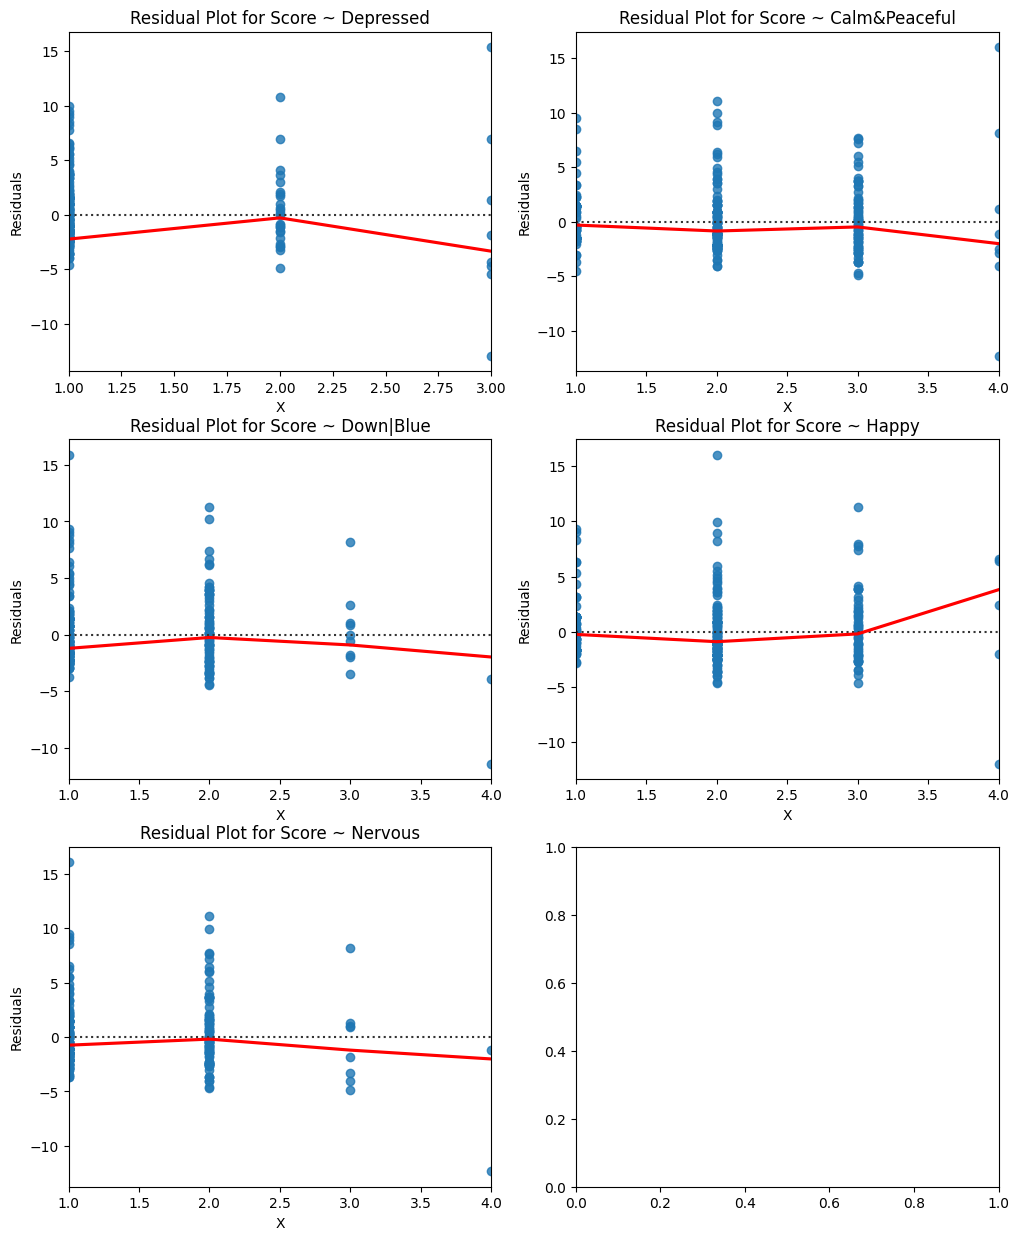

In [99]:
# Negative binomial distribution

X = model_data_df.iloc[:,2:]
Y = model_data_df['Rxx CESD SCORE (x ITEM)'] + 1

X['HOW OFTEN DEPRESSED PAST M'] = X['HOW OFTEN DEPRESSED PAST M'] * -1 + 5
X['HOW OFTEN DOWN OR BLUE PAST M'] = X['HOW OFTEN DOWN OR BLUE PAST M'] * -1 + 5
X['HOW OFTEN NERVOUS PAST M'] = X['HOW OFTEN NERVOUS PAST M'] * -1 + 5

X = sm.add_constant(X)
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = sm.GLM(Y_train, X_train, family=sm.families.NegativeBinomial()).fit()


# Make predictions
Y_pred = model.predict(X_test)

# Print coefficients
print('DEPRESSED', 'CALM&PEACEFUL', 'DOWN|BLUE', 'HAPPY', 'NERVOUS')
print(model.summary())
# Calculate and print metrics
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Y_test = Y_test.to_frame()
Y_test['Predict'] = 0
Y_test['Predict'] = Y_test['Predict'] + Y_pred
Y_test['Residual'] = Y_test['Rxx CESD SCORE (x ITEM)'] - Y_test['Predict']


temp_df = pd.concat([Y_test,X_test],axis=1)
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
sns.residplot(x='HOW OFTEN DEPRESSED PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[0,0])
axs[0,0].set_xlabel('X')
axs[0,0].set_ylabel('Residuals')
axs[0,0].set_title('Residual Plot for Score ~ Depressed')

sns.residplot(x='HOW OFTEN CALM & PEACEFUL PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[0,1])
axs[0,1].set_xlabel('X')
axs[0,1].set_ylabel('Residuals')
axs[0,1].set_title('Residual Plot for Score ~ Calm&Peaceful')

sns.residplot(x= 'HOW OFTEN DOWN OR BLUE PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[1,0])
axs[1,0].set_xlabel('X')
axs[1,0].set_ylabel('Residuals')
axs[1,0].set_title('Residual Plot for Score ~ Down|Blue')

sns.residplot(x='HOW OFTEN HAPPY PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[1,1])
axs[1,1].set_xlabel('X')
axs[1,1].set_ylabel('Residuals')
axs[1,1].set_title('Residual Plot for Score ~ Happy')

sns.residplot(x='HOW OFTEN NERVOUS PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[2,0])
axs[2,0].set_xlabel('X')
axs[2,0].set_ylabel('Residuals')
axs[2,0].set_title('Residual Plot for Score ~ Nervous')

plt.show()

In [100]:
predict_data_df = pd.concat([mental_health_df[['uid']],mental_health_df.loc[:,[
    'HOW OFTEN DEPRESSED PAST M',
    'HOW OFTEN CALM & PEACEFUL PAST M',
    'HOW OFTEN DOWN OR BLUE PAST M',
    'HOW OFTEN HAPPY PAST M',
    'HOW OFTEN NERVOUS PAST M',]].sparse.to_dense()],axis=1)
predict_data_df = predict_data_df.applymap(lambda x: None if x < 0 else x).dropna(axis=0)
X = predict_data_df.iloc[:,1:]


X['HOW OFTEN DEPRESSED PAST M'] = X['HOW OFTEN DEPRESSED PAST M'] * -1 + 5
X['HOW OFTEN DOWN OR BLUE PAST M'] = X['HOW OFTEN DOWN OR BLUE PAST M'] * -1 + 5
X['HOW OFTEN NERVOUS PAST M'] = X['HOW OFTEN NERVOUS PAST M'] * -1 + 5
#X = X.applymap(value_map.get)

predict_data_df['Predicted CESD'] = 0
predict_data_df['Predicted CESD'] = model.predict(sm.add_constant(X))

mental_health_df.drop('Predicted CESD',axis=1,inplace=True,errors='ignore')
mental_health_df = mental_health_df.merge(predict_data_df.loc[:,'Predicted CESD'],how='left',left_index=True,right_index=True)
mental_health_df.drop('Predicted CESD rounded',axis=1,inplace=True,errors='ignore')
mental_health_df['Predicted CESD rounded'] = mental_health_df['Predicted CESD'].round()

(0.0, 22.0)

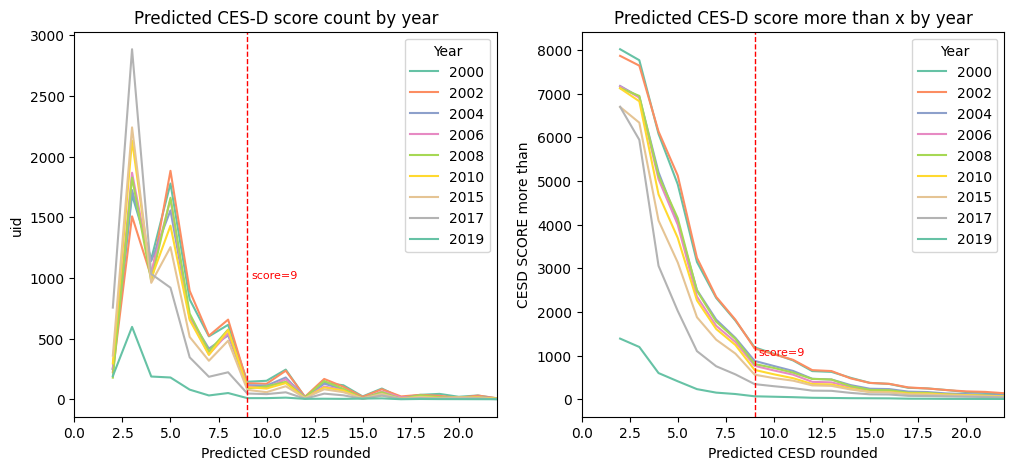

In [101]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

temp_df = mental_health_df.loc[mental_health_df['Predicted CESD rounded'] >= 0,:]
temp_df = temp_df.groupby(['Predicted CESD rounded','Year'])['uid'].count().reset_index()
temp_df['CESD SCORE more than'] = temp_df.groupby('Year')['uid'].transform(reverse_cumsum)


sns.lineplot(temp_df,x='Predicted CESD rounded',y='uid',hue='Year',ax=axs[0],palette='Set2')
axs[0].set_title("Predicted CES-D score count by year")
axs[0].axvline(x=9, color='r', linestyle='--', linewidth=1)
axs[0].annotate('score=9', xy=(9, 1000), xytext=(9.2, 1000),
             fontsize=8, color='red')
axs[0].set_xlim(0,22)

sns.lineplot(temp_df,x='Predicted CESD rounded',y='CESD SCORE more than',hue='Year',ax=axs[1],palette='Set2')
axs[1].set_title("Predicted CES-D score more than x by year")
axs[1].axvline(x=9, color='r', linestyle='--', linewidth=1)
axs[1].annotate('score=9', xy=(9, 1000), xytext=(9.2, 1000),
             fontsize=8, color='red')
axs[1].set_xlim(0,22)


C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:921: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  array = array.astype(new_dtype)
C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:921: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  array = array.astype(new_dtype)
C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:921: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the reques

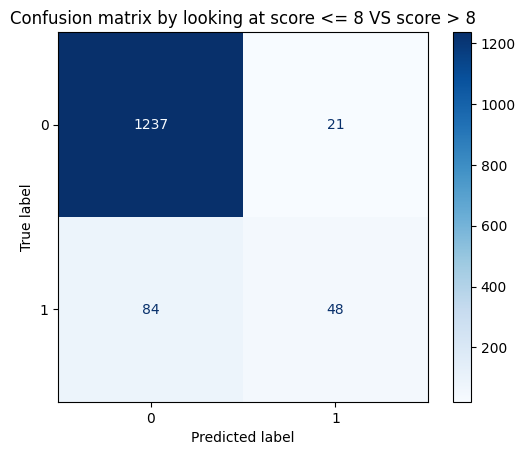

In [102]:
mental_health_df['CESD > 8'] = mental_health_df['Rxx CESD SCORE (x ITEM)'] > 8
mental_health_df['predicted CESD > 8'] = mental_health_df['Predicted CESD rounded'] > 8

cm_df = mental_health_df.loc[(mental_health_df['Rxx CESD SCORE (x ITEM)'].notnull()) & (mental_health_df['Predicted CESD rounded'].notnull()),:]
cm = confusion_matrix(cm_df['CESD > 8'], cm_df['predicted CESD > 8'])

# Option 1: Display using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix by looking at score <= 8 VS score > 8")
plt.show()

##### Other methods
In appendix as they didn't make a lot of difference

DEPRESSED CALM&PEACEFUL DOWN|BLUE HAPPY NERVOUS
Coefficients: [0.2457691  0.10534447 0.43341597 0.12916567 0.15913741]
Intercept: -0.5157203820198817
Mean Squared Error: 10.501726062779543
R^2 Score: 0.3435748510610155


C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


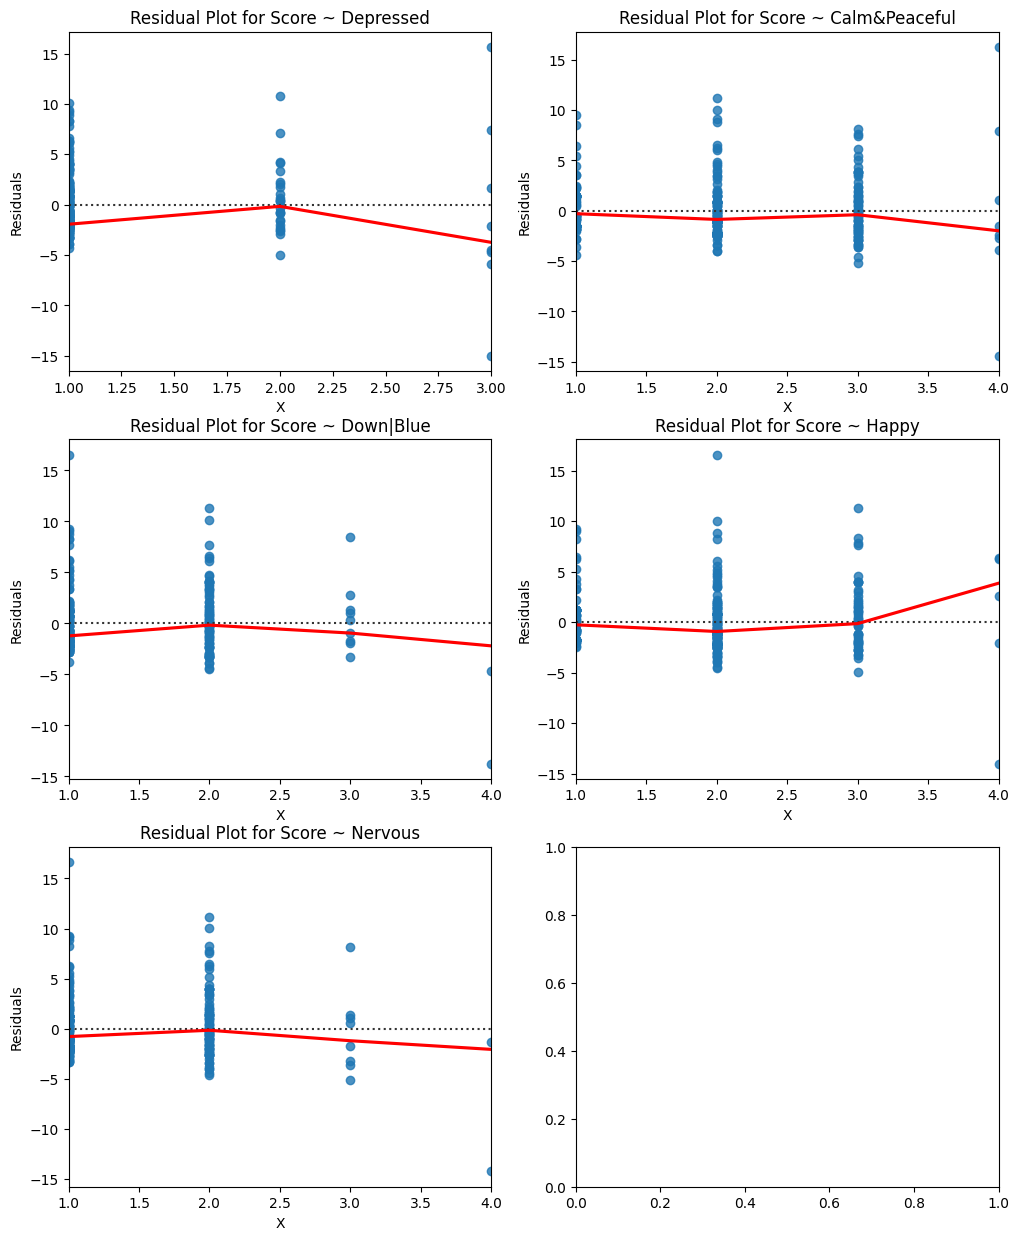

In [104]:
# Apply log to score (dependent) variable


X = model_data_df.iloc[:,2:]
Y = model_data_df['Rxx CESD SCORE (x ITEM)'] + 1
Y = Y.map(np.log)

X['HOW OFTEN DEPRESSED PAST M'] = X['HOW OFTEN DEPRESSED PAST M'] * -1 + 5
X['HOW OFTEN DOWN OR BLUE PAST M'] = X['HOW OFTEN DOWN OR BLUE PAST M'] * -1 + 5
X['HOW OFTEN NERVOUS PAST M'] = X['HOW OFTEN NERVOUS PAST M'] * -1 + 5


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create and train the model
model = LinearRegression()
model.fit(X_train, Y_train)

# Make predictions
Y_pred = model.predict(X_test)

# Print coefficients
print('DEPRESSED', 'CALM&PEACEFUL', 'DOWN|BLUE', 'HAPPY', 'NERVOUS')
print(f'Coefficients: {model.coef_}')
print(f'Intercept: {model.intercept_}')

# Calculate and print metrics
Y_pred = np.exp(Y_pred)
Y_test = np.exp(Y_test)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Y_test = Y_test.to_frame()
Y_test['Predict'] = 0
Y_test['Predict'] = Y_test['Predict'] + Y_pred
Y_test['Residual'] = Y_test['Rxx CESD SCORE (x ITEM)'] - Y_test['Predict']


temp_df = pd.concat([Y_test,X_test],axis=1)
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
sns.residplot(x='HOW OFTEN DEPRESSED PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[0,0])
axs[0,0].set_xlabel('X')
axs[0,0].set_ylabel('Residuals')
axs[0,0].set_title('Residual Plot for Score ~ Depressed')

sns.residplot(x='HOW OFTEN CALM & PEACEFUL PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[0,1])
axs[0,1].set_xlabel('X')
axs[0,1].set_ylabel('Residuals')
axs[0,1].set_title('Residual Plot for Score ~ Calm&Peaceful')

sns.residplot(x= 'HOW OFTEN DOWN OR BLUE PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[1,0])
axs[1,0].set_xlabel('X')
axs[1,0].set_ylabel('Residuals')
axs[1,0].set_title('Residual Plot for Score ~ Down|Blue')

sns.residplot(x='HOW OFTEN HAPPY PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[1,1])
axs[1,1].set_xlabel('X')
axs[1,1].set_ylabel('Residuals')
axs[1,1].set_title('Residual Plot for Score ~ Happy')

sns.residplot(x='HOW OFTEN NERVOUS PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[2,0])
axs[2,0].set_xlabel('X')
axs[2,0].set_ylabel('Residuals')
axs[2,0].set_title('Residual Plot for Score ~ Nervous')

plt.show()

C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


DEPRESSED CALM&PEACEFUL DOWN|BLUE HAPPY NERVOUS
                    Generalized Linear Model Regression Results                    
Dep. Variable:     Rxx CESD SCORE (x ITEM)   No. Observations:                 1100
Model:                                 GLM   Df Residuals:                     1094
Model Family:                     Gaussian   Df Model:                            5
Link Function:                    identity   Scale:                          7.6264
Method:                               IRLS   Log-Likelihood:                -2675.2
Date:                     Wed, 07 Aug 2024   Deviance:                       8343.2
Time:                             09:56:28   Pearson chi2:                 8.34e+03
No. Iterations:                          3   Pseudo R-squ. (CS):             0.5649
Covariance Type:                 nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------

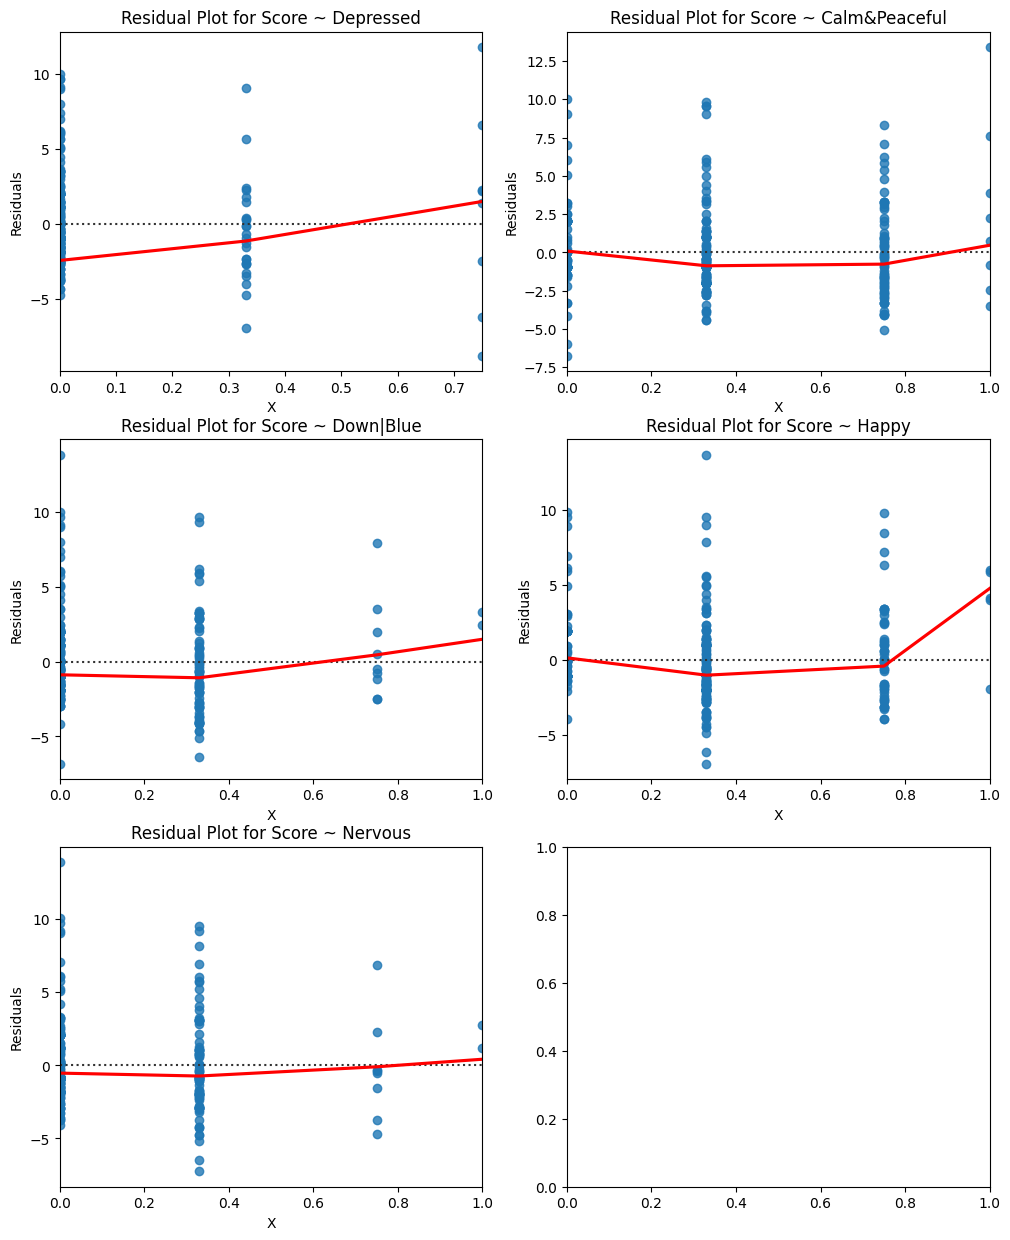

In [105]:
# Apply manual scaling from [1,2,3,4] to [0,0.33,0.75,1.0] to linear regression

X = model_data_df.iloc[:,2:]
Y = model_data_df['Rxx CESD SCORE (x ITEM)'] + 1

X['HOW OFTEN DEPRESSED PAST M'] = X['HOW OFTEN DEPRESSED PAST M'] * -1 + 5
X['HOW OFTEN DOWN OR BLUE PAST M'] = X['HOW OFTEN DOWN OR BLUE PAST M'] * -1 + 5
X['HOW OFTEN NERVOUS PAST M'] = X['HOW OFTEN NERVOUS PAST M'] * -1 + 5

value_map = {1:0.0, 2:0.33, 3:0.75, 4:1.0}
X = X.applymap(value_map.get)
X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = sm.GLM(Y_train, X_train, family=sm.families.Gaussian(sm.families.links.identity())).fit()



# Make predictions
Y_pred = model.predict(X_test)

# Print coefficients
print('DEPRESSED', 'CALM&PEACEFUL', 'DOWN|BLUE', 'HAPPY', 'NERVOUS')
print(model.summary())
# Calculate and print metrics
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Y_test = Y_test.to_frame()
Y_test['Predict'] = 0
Y_test['Predict'] = Y_test['Predict'] + Y_pred
Y_test['Residual'] = Y_test['Rxx CESD SCORE (x ITEM)'] - Y_test['Predict']


temp_df = pd.concat([Y_test,X_test],axis=1)
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
sns.residplot(x='HOW OFTEN DEPRESSED PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[0,0])
axs[0,0].set_xlabel('X')
axs[0,0].set_ylabel('Residuals')
axs[0,0].set_title('Residual Plot for Score ~ Depressed')

sns.residplot(x='HOW OFTEN CALM & PEACEFUL PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[0,1])
axs[0,1].set_xlabel('X')
axs[0,1].set_ylabel('Residuals')
axs[0,1].set_title('Residual Plot for Score ~ Calm&Peaceful')

sns.residplot(x= 'HOW OFTEN DOWN OR BLUE PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[1,0])
axs[1,0].set_xlabel('X')
axs[1,0].set_ylabel('Residuals')
axs[1,0].set_title('Residual Plot for Score ~ Down|Blue')

sns.residplot(x='HOW OFTEN HAPPY PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[1,1])
axs[1,1].set_xlabel('X')
axs[1,1].set_ylabel('Residuals')
axs[1,1].set_title('Residual Plot for Score ~ Happy')

sns.residplot(x='HOW OFTEN NERVOUS PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[2,0])
axs[2,0].set_xlabel('X')
axs[2,0].set_ylabel('Residuals')
axs[2,0].set_title('Residual Plot for Score ~ Nervous')

plt.show()

                    Generalized Linear Model Regression Results                    
Dep. Variable:     Rxx CESD SCORE (x ITEM)   No. Observations:                 1100
Model:                                 GLM   Df Residuals:                     1094
Model Family:                      Poisson   Df Model:                            5
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -2566.0
Date:                     Wed, 07 Aug 2024   Deviance:                       1817.9
Time:                             09:56:29   Pearson chi2:                 1.97e+03
No. Iterations:                          5   Pseudo R-squ. (CS):             0.6787
Covariance Type:                 nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


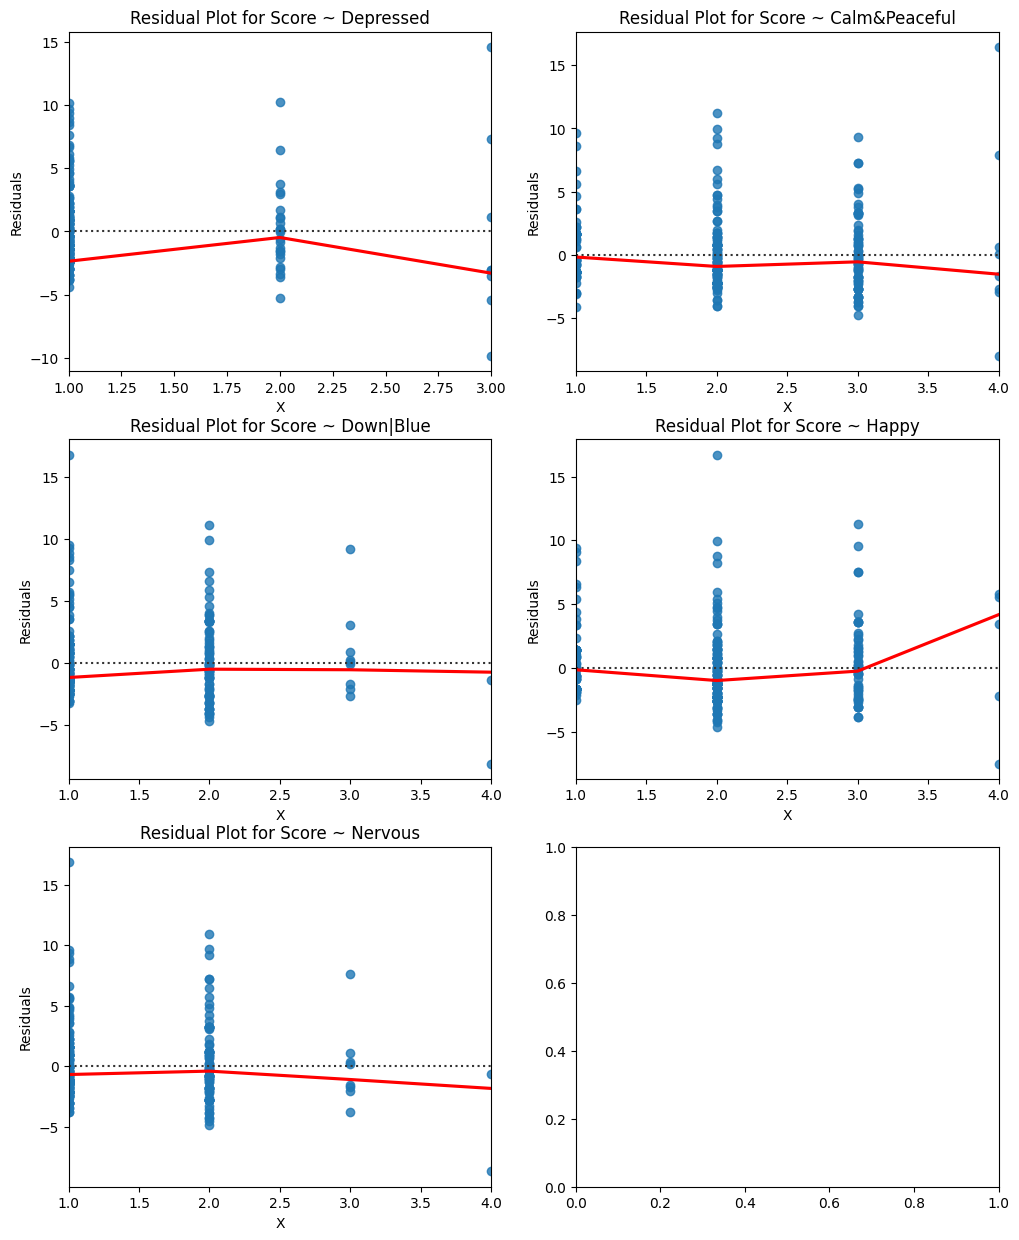

In [106]:
# Poisson distribution


X = model_data_df.iloc[:,2:]
Y = model_data_df['Rxx CESD SCORE (x ITEM)'] + 1

X['HOW OFTEN DEPRESSED PAST M'] = X['HOW OFTEN DEPRESSED PAST M'] * -1 + 5
X['HOW OFTEN DOWN OR BLUE PAST M'] = X['HOW OFTEN DOWN OR BLUE PAST M'] * -1 + 5
X['HOW OFTEN NERVOUS PAST M'] = X['HOW OFTEN NERVOUS PAST M'] * -1 + 5

X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

poisson_model = sm.GLM(Y_train, X_train, family=sm.families.Poisson()).fit()


# Make predictions
Y_pred = poisson_model.predict(X_test)

print(poisson_model.summary())
# Calculate and print metrics
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Y_test = Y_test.to_frame()
Y_test['Predict'] = 0
Y_test['Predict'] = Y_test['Predict'] + Y_pred
Y_test['Residual'] = Y_test['Rxx CESD SCORE (x ITEM)'] - Y_test['Predict']


temp_df = pd.concat([Y_test,X_test],axis=1)
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
sns.residplot(x='HOW OFTEN DEPRESSED PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[0,0])
axs[0,0].set_xlabel('X')
axs[0,0].set_ylabel('Residuals')
axs[0,0].set_title('Residual Plot for Score ~ Depressed')

sns.residplot(x='HOW OFTEN CALM & PEACEFUL PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[0,1])
axs[0,1].set_xlabel('X')
axs[0,1].set_ylabel('Residuals')
axs[0,1].set_title('Residual Plot for Score ~ Calm&Peaceful')

sns.residplot(x= 'HOW OFTEN DOWN OR BLUE PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[1,0])
axs[1,0].set_xlabel('X')
axs[1,0].set_ylabel('Residuals')
axs[1,0].set_title('Residual Plot for Score ~ Down|Blue')

sns.residplot(x='HOW OFTEN HAPPY PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[1,1])
axs[1,1].set_xlabel('X')
axs[1,1].set_ylabel('Residuals')
axs[1,1].set_title('Residual Plot for Score ~ Happy')

sns.residplot(x='HOW OFTEN NERVOUS PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[2,0])
axs[2,0].set_xlabel('X')
axs[2,0].set_ylabel('Residuals')
axs[2,0].set_title('Residual Plot for Score ~ Nervous')

plt.show()

C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\hiron\AppData\Roaming\Python\Python311\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


DEPRESSED CALM&PEACEFUL DOWN|BLUE HAPPY NERVOUS
                    Generalized Linear Model Regression Results                    
Dep. Variable:     Rxx CESD SCORE (x ITEM)   No. Observations:                 1100
Model:                                 GLM   Df Residuals:                     1094
Model Family:                     Gaussian   Df Model:                            5
Link Function:                    identity   Scale:                          7.7098
Method:                               IRLS   Log-Likelihood:                -2681.2
Date:                     Wed, 07 Aug 2024   Deviance:                       8434.5
Time:                             09:56:30   Pearson chi2:                 8.43e+03
No. Iterations:                          3   Pseudo R-squ. (CS):             0.5562
Covariance Type:                 nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------

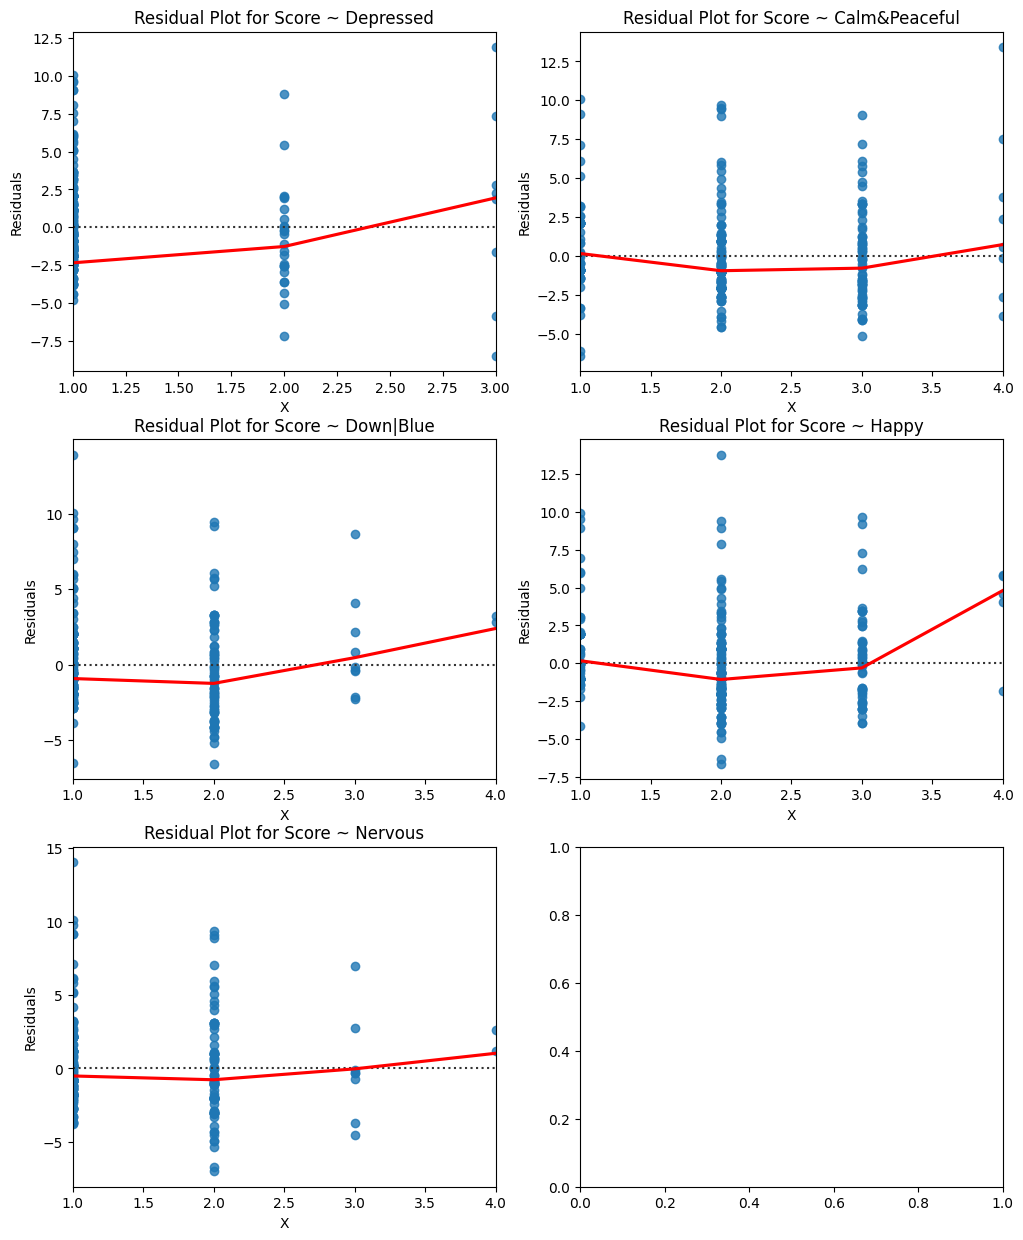

In [107]:
# Linear regression


X = model_data_df.iloc[:,2:]
Y = model_data_df['Rxx CESD SCORE (x ITEM)'] + 1

X['HOW OFTEN DEPRESSED PAST M'] = X['HOW OFTEN DEPRESSED PAST M'] * -1 + 5
X['HOW OFTEN DOWN OR BLUE PAST M'] = X['HOW OFTEN DOWN OR BLUE PAST M'] * -1 + 5
X['HOW OFTEN NERVOUS PAST M'] = X['HOW OFTEN NERVOUS PAST M'] * -1 + 5

X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = sm.GLM(Y_train, X_train, family=sm.families.Gaussian(sm.families.links.identity())).fit()



# Make predictions
Y_pred = model.predict(X_test)

# Print coefficients
print('DEPRESSED', 'CALM&PEACEFUL', 'DOWN|BLUE', 'HAPPY', 'NERVOUS')
print(model.summary())
# Calculate and print metrics
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Y_test = Y_test.to_frame()
Y_test['Predict'] = 0
Y_test['Predict'] = Y_test['Predict'] + Y_pred
Y_test['Residual'] = Y_test['Rxx CESD SCORE (x ITEM)'] - Y_test['Predict']


temp_df = pd.concat([Y_test,X_test],axis=1)
fig, axs = plt.subplots(3, 2, figsize=(12, 15))
sns.residplot(x='HOW OFTEN DEPRESSED PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[0,0])
axs[0,0].set_xlabel('X')
axs[0,0].set_ylabel('Residuals')
axs[0,0].set_title('Residual Plot for Score ~ Depressed')

sns.residplot(x='HOW OFTEN CALM & PEACEFUL PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[0,1])
axs[0,1].set_xlabel('X')
axs[0,1].set_ylabel('Residuals')
axs[0,1].set_title('Residual Plot for Score ~ Calm&Peaceful')

sns.residplot(x= 'HOW OFTEN DOWN OR BLUE PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[1,0])
axs[1,0].set_xlabel('X')
axs[1,0].set_ylabel('Residuals')
axs[1,0].set_title('Residual Plot for Score ~ Down|Blue')

sns.residplot(x='HOW OFTEN HAPPY PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[1,1])
axs[1,1].set_xlabel('X')
axs[1,1].set_ylabel('Residuals')
axs[1,1].set_title('Residual Plot for Score ~ Happy')

sns.residplot(x='HOW OFTEN NERVOUS PAST M', y='Residual', data=temp_df, lowess=True, line_kws={'color':'red'}, ax=axs[2,0])
axs[2,0].set_xlabel('X')
axs[2,0].set_ylabel('Residuals')
axs[2,0].set_title('Residual Plot for Score ~ Nervous')

plt.show()

In [108]:
# Decision tree


X = model_data_df.iloc[:,2:]
Y = model_data_df['Rxx CESD SCORE (x ITEM)'] + 1

X['HOW OFTEN DEPRESSED PAST M'] = X['HOW OFTEN DEPRESSED PAST M'] * -1 + 5
X['HOW OFTEN DOWN OR BLUE PAST M'] = X['HOW OFTEN DOWN OR BLUE PAST M'] * -1 + 5
X['HOW OFTEN NERVOUS PAST M'] = X['HOW OFTEN NERVOUS PAST M'] * -1 + 5

X = sm.add_constant(X)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_train, Y_train)


# Make predictions
Y_pred = tree.predict(X_test)

# Print coefficients
print('DEPRESSED', 'CALM&PEACEFUL', 'DOWN|BLUE', 'HAPPY', 'NERVOUS')
print(model.summary())
# Calculate and print metrics
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Y_test = Y_test.to_frame()
Y_test['Predict'] = 0
Y_test['Predict'] = Y_test['Predict'] + Y_pred
Y_test['Residual'] = Y_test['Rxx CESD SCORE (x ITEM)'] - Y_test['Predict']


temp_df = pd.concat([Y_test,X_test],axis=1)

plt.show()

DEPRESSED CALM&PEACEFUL DOWN|BLUE HAPPY NERVOUS
                    Generalized Linear Model Regression Results                    
Dep. Variable:     Rxx CESD SCORE (x ITEM)   No. Observations:                 1100
Model:                                 GLM   Df Residuals:                     1094
Model Family:                     Gaussian   Df Model:                            5
Link Function:                    identity   Scale:                          7.7098
Method:                               IRLS   Log-Likelihood:                -2681.2
Date:                     Wed, 07 Aug 2024   Deviance:                       8434.5
Time:                             09:56:31   Pearson chi2:                 8.43e+03
No. Iterations:                          3   Pseudo R-squ. (CS):             0.5562
Covariance Type:                 nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------

### Checking sample size for cohabit/marriage and CESD score intersection

__Questions to consider__
   * How many people are married/cohabitted in Year 2019/2021?
   * How many people were never married/cohabited in Year 2019/2021? 
   * What percentage of people had high CESD score for that interview? 
   * How long have the people been cohabitted/married at that time? 

#### Cohabit

__Observations__ 
   * Most people (~80%) have cohabitted at least once when surveyed 2019/2021
   * When looking at CESD score distribution between cohabitted VS not cohabitting, there is a statistically significant difference in terms of distribution (based on chi-squared, Man-U & Kolmogorov–Smirnov test)
   * Mean value has 1~2 point difference, however variance value is higher than mean
   * When binning the CESD score by intervals of three (0-2, 3-5, ...), chi-squared did NOT return statistical significance

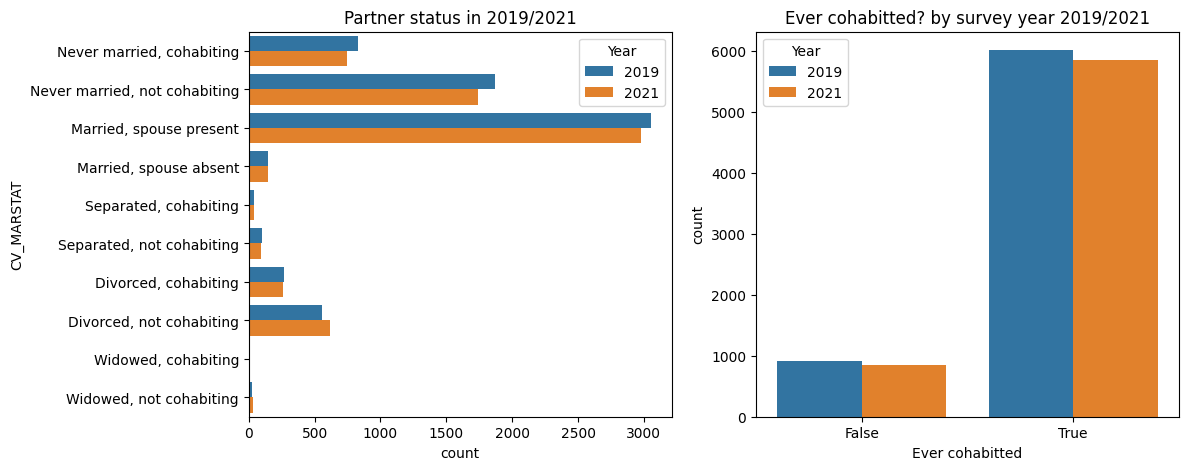

In [111]:
# Checking for the partner status survey question during 2019/2021 survey year
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cohab_mhealth_df = tidy_df.loc[tidy_df['Year'].isin([2019,2021]),['uid','Year','CV_MARSTAT']]
cohab_mhealth_df['CV_MARSTAT'] = cohab_mhealth_df['CV_MARSTAT'].map(cv_marstat_map)
sns.countplot(data=cohab_mhealth_df, y='CV_MARSTAT', order = cv_marstat_map.values(),hue='Year',ax=axs[0])
axs[0].set_title("Partner status in 2019/2021")


# Looking at # of people that have ever cohabitted by survey year
temp_df = partner_df.loc[partner_df['MAR_COHABITATION'].isin([101,201]),:].groupby('uid')[['year-month','year']].min()
temp_df['year'] = temp_df['year'].astype(int)
temp_df = temp_df.rename(columns={'year-month':'First cohabit year-month','year':'First cohabit year'})
cohab_mhealth_df = cohab_mhealth_df.merge(temp_df, how='left',on='uid')
cohab_mhealth_df['Ever cohabitted'] = (cohab_mhealth_df['First cohabit year']<= cohab_mhealth_df['Year'])
sns.countplot(cohab_mhealth_df,x='Ever cohabitted',hue='Year',ax=axs[1])
axs[1].set_title("Ever cohabitted? by survey year 2019/2021")
plt.show()

cohab_mhealth_df.drop('Rxx CESD SCORE (x ITEM)',axis=1,errors='ignore',inplace=True)
cohab_mhealth_df = cohab_mhealth_df.merge(mental_health_df[['uid','Year','Rxx CESD SCORE (x ITEM)']],how='left',on=['uid','Year'])


C:\Users\hiron\AppData\Local\Temp\ipykernel_11452\3039452299.py:19: FutureWarning: In a future version, passing a SparseArray to pd.Index will store that array directly instead of converting to a dense numpy ndarray. To retain the old behavior, use pd.Index(arr.to_numpy()) instead
  temp_df = temp_df.groupby(['Rxx CESD SCORE (x ITEM)','cohabit'])['uid'].count().to_frame().reset_index()


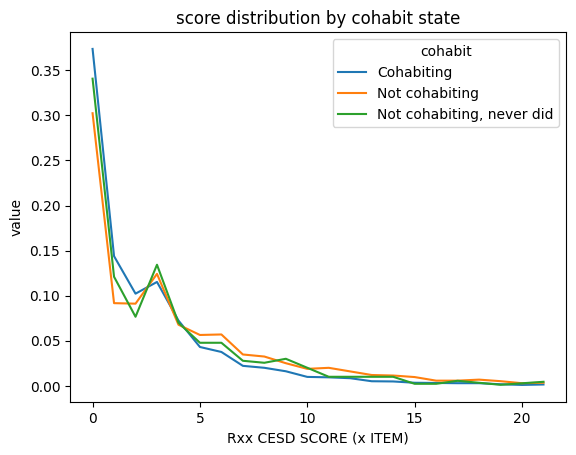

In [112]:
#Visually comparing distribution of CESD score for cohabit VS not cohabitting (and if never cohabitted or not)
MARSTAT_mapping = {
    'Never married, cohabiting': 'Cohabiting', 
    'Never married, not cohabiting': 'Not cohabiting',
    'Married, spouse present': 'Cohabiting',
    'Married, spouse absent': 'Not cohabiting',
    'Separated, cohabiting': 'Cohabiting',
    'Separated, not cohabiting': 'Not cohabiting',
    'Divorced, cohabiting': 'Cohabiting',
    'Divorced, not cohabiting': 'Not cohabiting',
    'Widowed, cohabiting': 'Cohabiting',
    'Widowed, not cohabiting': 'Not cohabiting',
}

cohab_mhealth_df['cohabit'] =  cohab_mhealth_df['CV_MARSTAT'].map(MARSTAT_mapping) + \
                            cohab_mhealth_df['Ever cohabitted'].map(lambda x: '' if x else ', never did')
temp_df = cohab_mhealth_df[(cohab_mhealth_df['Year'] == 2019) & (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0)].copy()
temp_df = temp_df.loc[temp_df['cohabit'] != 'Cohabiting, never did']
temp_df = temp_df.groupby(['Rxx CESD SCORE (x ITEM)','cohabit'])['uid'].count().to_frame().reset_index()
temp_df = temp_df.pivot(index='Rxx CESD SCORE (x ITEM)',columns='cohabit')

#Show percentage of each count per column
column_totals = temp_df.sum(axis=0)
percentage_df = temp_df.div(column_totals, axis=1)
show((temp_df.astype(str) + ' (' + (percentage_df*100).round(2).astype(str) + '%)'))
temp_df.fillna(0,inplace=True)

sns.lineplot(percentage_df.melt(ignore_index=False).reset_index(), x='Rxx CESD SCORE (x ITEM)',y='value',hue='cohabit').set_title("score distribution by cohabit state")
plt.show()



In [113]:
# Running a few statistical tests. Not all three are needed, but good to see if there are any significant differences


data1 = cohab_mhealth_df.loc[(cohab_mhealth_df['Year'] == 2019) & 
                             (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0) &  
                             (cohab_mhealth_df['cohabit'] =='Cohabiting'),'Rxx CESD SCORE (x ITEM)']
data2 = cohab_mhealth_df.loc[(cohab_mhealth_df['Year'] == 2019) & 
                             (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0) &  
                             (cohab_mhealth_df['cohabit'] =='Not cohabiting'),'Rxx CESD SCORE (x ITEM)']


u_statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
print(f"U Statistic: {u_statistic}")
print(f"P Value: {p_value}")
print('')

ks_statistic, p_value = ks_2samp(data1, data2)
print(f'K-S Statistic: {ks_statistic}')
print(f'P-value: {p_value}')
print('')

chi2, p, dof, expected = chi2_contingency(temp_df.iloc[:,[0,1]])
print(f'Chi-square Statistic: {chi2}')
print(f'P-value: {p}')
print(f'Degrees of Freedom: {dof}')
print('')




U Statistic: 3061718.5
P Value: 7.610611579533172e-24

K-S Statistic: 0.1345754979012382
P-value: 5.931335006003484e-20

Chi-square Statistic: 154.278875892137
P-value: 2.6900604812933282e-22
Degrees of Freedom: 21



In [114]:
cohab_mhealth_df['Rxx CESD SCORE (x ITEM)']

0        0.0
1        0.0
2        7.0
3        7.0
4        0.0
        ... 
13634    0.0
13635    4.0
13636    4.0
13637    3.0
13638    3.0
Name: Rxx CESD SCORE (x ITEM), Length: 13639, dtype: Sparse[float64, nan]

In [115]:
print("Mean CESD scores:")
print(cohab_mhealth_df.groupby(['Year','cohabit'])['Rxx CESD SCORE (x ITEM)'].mean())
cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] = cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'].sparse.to_dense()
print(cohab_mhealth_df.groupby(['Year','cohabit'])['Rxx CESD SCORE (x ITEM)'].std())


Mean CESD scores:
Year  cohabit                  
2019  Cohabiting                   2.556775
      Cohabiting, never did        4.200000
      Not cohabiting               3.761077
      Not cohabiting, never did    3.118551
2021  Cohabiting                   2.848733
      Cohabiting, never did        0.750000
      Not cohabiting               4.198435
      Not cohabiting, never did    3.077922
Name: Rxx CESD SCORE (x ITEM), dtype: Sparse[float64, nan]
Year  cohabit                  
2019  Cohabiting                   3.508876
      Cohabiting, never did        7.259477
      Not cohabiting               4.498299
      Not cohabiting, never did    3.949294
2021  Cohabiting                   3.811225
      Cohabiting, never did        1.500000
      Not cohabiting               4.915651
      Not cohabiting, never did    4.002195
Name: Rxx CESD SCORE (x ITEM), dtype: float64


##### Binning for cohabitted

In [117]:
def bin_cesd(score):
    """ 
    Function to bin the CESD score 
    """
    if (score is None) or (score < 0): 
        return np.NaN
    elif score < 3:
        return '00-02'
    elif score < 6:
        return '03-05'
    elif score < 9:
        return '06-08'
    elif score < 12:
        return '09-11'
    elif score < 15:
        return '12-14'
    elif score < 18:
        return '15-17'
    else:
        return '18-21'


cohab_mhealth_df['CESD bin'] = cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'].map(bin_cesd)
temp_df = cohab_mhealth_df[cohab_mhealth_df['Year'] == 2019].groupby(['CESD bin','Ever cohabitted'])['uid'].count().to_frame()
temp_df = temp_df.reset_index().pivot(index='CESD bin',columns='Ever cohabitted')

#Show percentage of each count per column
column_totals = temp_df.sum(axis=0)
percentage_df = temp_df.div(column_totals, axis=1) * 100
show((temp_df.astype(str) + ' (' + percentage_df.round(2).astype(str) + '%)'))
# Running a few statistical tests. Not all three are needed, but good to see if there are any significant differences


data1 = cohab_mhealth_df.loc[(cohab_mhealth_df['Year'] == 2019) & 
                             (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0) &  
                             (cohab_mhealth_df['cohabit'] =='Cohabiting'),'CESD bin']
data2 = cohab_mhealth_df.loc[(cohab_mhealth_df['Year'] == 2019) & 
                             (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0) &  
                             (cohab_mhealth_df['cohabit'] =='Not cohabiting'),'CESD bin']

chi2, p, dof, expected = chi2_contingency(temp_df.iloc[:,[0,1]])
print(f'Chi-square Statistic: {chi2}')
print(f'P-value: {p}')
print(f'Degrees of Freedom: {dof}')
print('')




Chi-square Statistic: 9.373113326856064
P-value: 0.15365612131036233
Degrees of Freedom: 6



#### Married

__Observations__ 
   * Results are similar to cohabit, as there is statistically significant distribution difference of CESD score between married & never married 
   * However unlike cohabit, even with binning there still was statistically significance in distribution (chi-square)

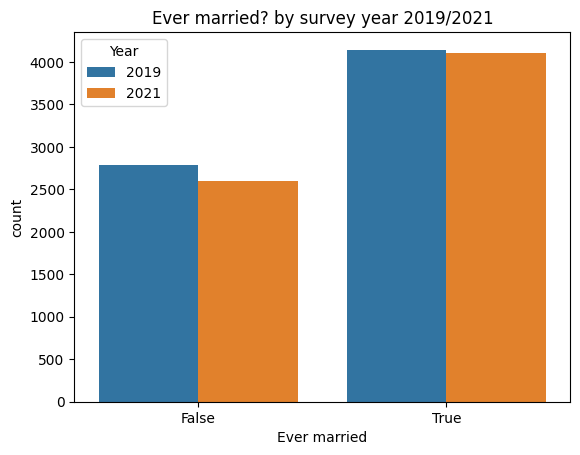

In [119]:
temp_df = partner_df.loc[partner_df['MAR_COHABITATION'].isin([201]),:].groupby('uid')[['year-month','year']].min()
temp_df['year'] = temp_df['year'].astype(int)
temp_df = temp_df.rename(columns={'year-month':'First marriage year-month','year':'First marriage year'})
cohab_mhealth_df.drop(['First marriage year-month','First marriage year'],axis=1,errors='ignore',inplace=True)
cohab_mhealth_df = cohab_mhealth_df.merge(temp_df, how='left',on='uid')
cohab_mhealth_df['Ever married'] = (cohab_mhealth_df['First marriage year']<= cohab_mhealth_df['Year'])
sns.countplot(cohab_mhealth_df,x='Ever married',hue='Year').set_title("Ever married? by survey year 2019/2021")
plt.show()


In [120]:
print("Mean CESD scores:")
print(cohab_mhealth_df.groupby(['Year','Ever married'])['Rxx CESD SCORE (x ITEM)'].mean())


Mean CESD scores:
Year  Ever married
2019  False           3.437836
      True            2.606565
2021  False           3.711103
      True            2.949537
Name: Rxx CESD SCORE (x ITEM), dtype: float64


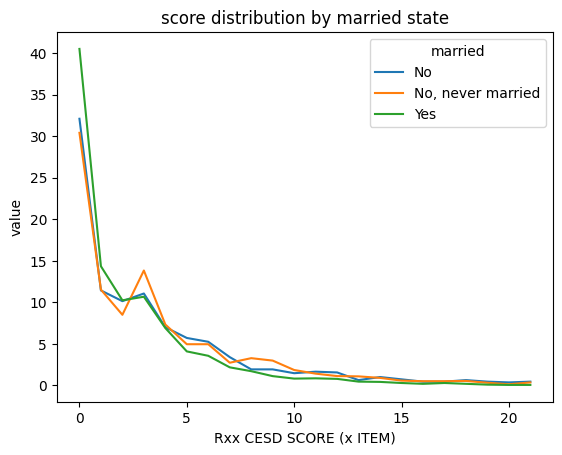

In [121]:
cohab_mhealth_df['married'] =  cohab_mhealth_df['CV_MARSTAT'].map(lambda x: "Yes" if x == 'Married, spouse present' else "No") 
cohab_mhealth_df['married'] = cohab_mhealth_df['married'] + cohab_mhealth_df['Ever married'].map(lambda x: '' if x else ', never married')
cohab_mhealth_df.loc[cohab_mhealth_df['married'] == 'Yes, never married','married'] = None
temp_df = cohab_mhealth_df[(cohab_mhealth_df['Year'] == 2019) & (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0)].copy()
temp_df = temp_df.loc[temp_df['married'] != 'Yes, never did']
temp_df = temp_df.groupby(['Rxx CESD SCORE (x ITEM)','married'])['uid'].count().to_frame().reset_index()
temp_df = temp_df.pivot(index='Rxx CESD SCORE (x ITEM)',columns='married')

#Show percentage of each count per column
column_totals = temp_df.sum(axis=0)
percentage_df = temp_df.div(column_totals, axis=1) * 100
show((temp_df.astype(str) + ' (' + percentage_df.round(2).astype(str) + '%)'))
temp_df.fillna(0,inplace=True)

sns.lineplot(percentage_df.melt(ignore_index=False).reset_index(), x='Rxx CESD SCORE (x ITEM)',y='value',hue='married').set_title("score distribution by married state")
plt.show()


In [122]:
# Running a few statistical tests. Not all three are needed, but good to see if there are any significant differences


data1 = cohab_mhealth_df.loc[(cohab_mhealth_df['Year'] == 2019) & 
                             (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0) &  
                             (cohab_mhealth_df['married'] =='Yes'),'Rxx CESD SCORE (x ITEM)']
data2 = cohab_mhealth_df.loc[(cohab_mhealth_df['Year'] == 2019) & 
                             (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0) &  
                             (cohab_mhealth_df['married'] =='No, never married'),'Rxx CESD SCORE (x ITEM)']


u_statistic, p_value = mannwhitneyu(data1, data2, alternative='two-sided')
print(f"U Statistic: {u_statistic}")
print(f"P Value: {p_value}")
print('')

ks_statistic, p_value = ks_2samp(data1, data2)
print(f'K-S Statistic: {ks_statistic}')
print(f'P-value: {p_value}')
print('')

chi2, p, dof, expected = chi2_contingency(temp_df.loc[:,[("uid","Yes"),("uid","No")]])
print(f'Chi-square Statistic: {chi2}')
print(f'P-value: {p}')
print(f'Degrees of Freedom: {dof}')
print('')



U Statistic: 3431934.0
P Value: 7.783201935731162e-31

K-S Statistic: 0.14656062924135213
P-value: 2.1719924464511683e-27

Chi-square Statistic: 86.38874091446193
P-value: 6.72417883777629e-10
Degrees of Freedom: 21



##### Binning for married

In [124]:
temp_df = cohab_mhealth_df[cohab_mhealth_df['Year'] == 2019].groupby(['CESD bin','married'])['uid'].count().to_frame()
temp_df = temp_df.reset_index().pivot(index='CESD bin',columns='married')

#Show percentage of each count per column
column_totals = temp_df.sum(axis=0)
percentage_df = temp_df.div(column_totals, axis=1) * 100
show((temp_df.astype(str) + ' (' + percentage_df.round(2).astype(str) + '%)'))
# Running a few statistical tests. Not all three are needed, but good to see if there are any significant differences


data1 = cohab_mhealth_df.loc[(cohab_mhealth_df['Year'] == 2019) & 
                             (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0) &  
                              (cohab_mhealth_df['Ever married'] ==False),'CESD bin']
data2 = cohab_mhealth_df.loc[(cohab_mhealth_df['Year'] == 2019) & 
                             (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0) &  
                              (cohab_mhealth_df['Ever married'] ==True),'CESD bin']

chi2, p, dof, expected = chi2_contingency(temp_df.loc[:,[("uid","Yes"),("uid","No")]])
print(f'Chi-square Statistic: {chi2}')
print(f'P-value: {p}')
print(f'Degrees of Freedom: {dof}')
print('')




Chi-square Statistic: 76.63666993279953
P-value: 1.7660363803075325e-14
Degrees of Freedom: 6



##### Length of marriage when interviewed

Text(0.5, 1.0, '100% stacked version')

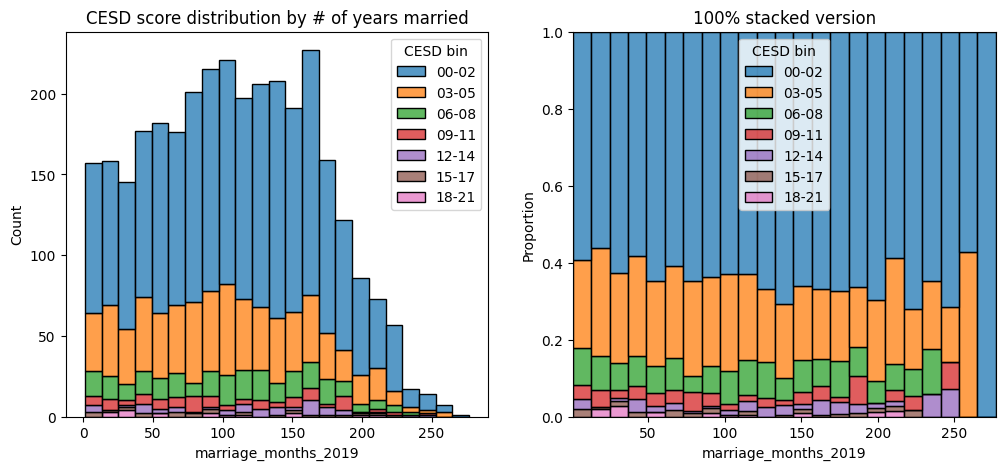

In [126]:
def diff_months(row):
    y2 = int(row['2019 interview year-month'][:4])
    y1 = int(row['marriage_start'][:4])
    m2 = int(row['2019 interview year-month'][-2:])
    m1 = int(row['marriage_start'][-2:])
    return (y2-y1) * 12 + (m2-m1)

marriage_2019_df = tidy_df.loc[(tidy_df['Year'] == 2019) & 
                      (tidy_df['CV_INTERVIEW_DATE_M'] >0),['uid','CV_INTERVIEW_DATE_M','CV_INTERVIEW_DATE_Y']]

marriage_2019_df['CV_INTERVIEW_DATE_Y'] = marriage_2019_df['CV_INTERVIEW_DATE_Y'].sparse.to_dense().astype(int).astype(str)
marriage_2019_df['CV_INTERVIEW_DATE_M'] = ('0' + marriage_2019_df['CV_INTERVIEW_DATE_M'].sparse.to_dense().astype(int).astype(str)).str[:-1]
                                                                            

marriage_2019_df['2019 interview year-month'] = marriage_2019_df['CV_INTERVIEW_DATE_Y'] + '-' + marriage_2019_df['CV_INTERVIEW_DATE_M']

#Pandas doesn't have an easy way to do range join (which can be done in one SQL statement)
marriage_2019_df = marriage_2019_df.merge(marriage_stats_df,on='uid')
marriage_2019_df = marriage_2019_df.loc[(marriage_2019_df['2019 interview year-month'] > marriage_2019_df['marriage_start']) & 
                                        (marriage_2019_df['2019 interview year-month'] < marriage_2019_df['marriage_end']),:]
marriage_2019_df['marriage_months_2019'] = marriage_2019_df.apply(diff_months,axis=1)

temp_df = cohab_mhealth_df.loc[(cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] >= 0) &
                               (cohab_mhealth_df['Year']==2019),['uid','Rxx CESD SCORE (x ITEM)','CESD bin']]
marriage_2019_df = marriage_2019_df.merge(temp_df,on='uid')
hue_order = ['00-02','03-05','06-08','09-11','12-14','15-17','18-21']

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=marriage_2019_df,x='marriage_months_2019', hue='CESD bin', hue_order=hue_order,multiple='stack',binwidth=12, ax=axs[0])
axs[0].set_title("CESD score distribution by # of years married")
sns.histplot(data=marriage_2019_df,x='marriage_months_2019', hue='CESD bin', hue_order=hue_order,multiple='fill',stat='proportion',binwidth=12,ax=axs[1])
axs[1].set_title("100% stacked version")


##### CESD score > 8
   * There is statistical signifance when looked at binomial distribution as well 

In [128]:
cohab_mhealth_df['CESD above 8'] = (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] > 8)
cohab_mhealth_df['CESD above 7'] = (cohab_mhealth_df['Rxx CESD SCORE (x ITEM)'] > 7)
temp_df = cohab_mhealth_df[cohab_mhealth_df['Year']==2019].pivot_table(values='uid',index='CESD above 8',columns='married',aggfunc='count')
show(temp_df)


# Counts and sample sizes
nobs = temp_df.loc[:,['No, never married','Yes']].sum().to_list()
counts = temp_df.loc[True,['No, never married','Yes']].to_list()

# Perform the two-proportion z-test
z_stat, p_value = sm.stats.proportions_ztest(counts, nobs, alternative='two-sided')

print(f"Z-statistic: {z_stat}")
print(f"p-value: {p_value}")

Z-statistic: 8.814124834656551
p-value: 1.2062359211006765e-18


## Problem/estimand definition


### Key findings: 
   * We have about 7000 participants during last interview (2021), ~ 78% from initial survey
   * Age is around 40 +/- 2 years at 2021 interview, gender mostly even
   * ~80% have cohabitted at least once, and 60% at least married once in 2019/2021 survey
   * We have two potential source for mental health: CES-D (used for depression scoring) or "How often..." (e.g. depressed, happy, down, etc) questions
   * The CES-D score is the 7 question (i.e. light version) instead of the full version (20 questions). There isn't clear threshold on at what point it shows depression, however some study suggests score of [8](https://link.springer.com/article/10.1007/s00127-012-0650-2) or [9](https://www.mdpi.com/1660-4601/18/3/1361) or higher to have significant likelihood of depression.    
	    * We have about 700 people that have score > 9 (significant likelihood of being depressed). This is ~10% of the total surveyor
   * Since CESD was only available 2019 & 2021 but "How often" was asked almost every year, I attempted to infer CESD score via the "How often" questions using few regression methods, with the intent of having more options of mental health data use. However, I wasn't able to get good accuracy, perhaps due to noise in data.  
   * The CESD score distribution btw 2019 and 2021 is comparable
   * CESD score distribution was compared between cohabitting VS not cohabitting in 2019 survey year data
      * Statistical significance was observed using Mann-U and Chi-square, however when the score was binned ([0-2], [3-5], [6-8],...) , there wasn't significance. 
	  * Also divided not cohabitting to "Not cohabitting, cohabitted before" and "Not cohabitting, never cohabitted" and compared w/ cohabitted, but results were similar. 
   * Similar comparison was done for married VS not married. There, statistical significance was there even for binned, and also checked for binomial distribution
      * ...Though high level differences in distribution doesn't tell the whole story, it is a sign
   * In either case of cohabit or marriage, the CESD scores are heavily skewed to zero. 

### Definition
Based on the information above, the project objective 

__"Understand the impact of cohabitation & marriage to mental health__"

Can be refined as a problem statement of: 

__What is the impact of marriage to CES-D (i.e. depression) score?__ 

Or in more rigorous estimand forms: 

   * __In US national longitudinal survey (NLS) 97 respondents, what is the <span style="color:blue">absolute/relative difference in mean of CES-D7 (i.e. depression) score </span> in the 2021 survey between the respondents that are married VS never married at the time of the survey?__
   * __In US national longitudinal survey (NLS) 97 respondents, what is the <span style="color:green"> probability difference to scoring 8 or higher (i.e. sig. chance in having depression)</span> in the 2021 survey between the respondents that are married VS never married at the time of the survey?__

We will proceed with the latter because the point difference (the former) may not be intuitive and meaningful enough. For example, getting results of "There is average of 1.5 point increase in CESD score when getting married" is harder to interpret than "There is an average decrease of 30% getting CESD score > 8 when married". 

## Export

In [238]:
# Exporting out the dataframes
exports = {
    'tidy_df': tidy_df,
    'main_df': main_df,
    'partner_df': partner_df,
    'mental_health_df': mental_health_df,
    'codebook_df':codebook_df,
    'cohab_mhealth_df':cohab_mhealth_df,
    'source_df': source_df,
    'marriage_stats_df': marriage_stats_df,
    'interview_df': interview_df,
}

#I realized it has less typing if I don't have whitespaces when putting stats_model formulas, so replace w/ underscore as it's being exported
for key, the_df in exports.items():
    the_df.rename(columns=dict([(x,x.replace(" ","_")) for x in the_df.columns.to_list()])).to_pickle('temp/' + key + '.pkl')
    

